# Projet 7 : Implémentez un modèle de scoring 

In [1]:
#imports 
import pandas as pd

from analysis_cleaning_functions import *
import gc
import numpy as np
from numpy import array
from numpy import argmax

import os
import datetime
import time
import random
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
   
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE 

from sklearn.metrics import confusion_matrix
import pickle
import shap

from lightgbm import LGBMClassifier
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, auc, precision_recall_curve

from pycaret.classification import * 

## Data loading 

In [2]:
#traduire les labels en anglais
directory= "../data/"
df_application_test = pd.read_csv(directory+"application_test.csv", error_bad_lines=False, sep=',')
df_application_train = pd.read_csv(directory+"application_train.csv", error_bad_lines=False, sep=',')
df_bureau= pd.read_csv(directory+'bureau.csv', error_bad_lines=False, sep=',')
df_bureau_balance = pd.read_csv(directory+'bureau_balance.csv', error_bad_lines=False, sep=',')
df_credit_card_balance = pd.read_csv(directory+"credit_card_balance.csv", error_bad_lines=False, sep=',')
df_installments_payments = pd.read_csv(directory+"installments_payments.csv", error_bad_lines=False, sep=',')
df_POS_CASH_balance = pd.read_csv(directory+"POS_CASH_balance.csv", error_bad_lines=False, sep=',')
df_previous_application = pd.read_csv(directory+"previous_application.csv", error_bad_lines=False, sep=',')
df_sample_submission = pd.read_csv(directory+"sample_submission.csv", error_bad_lines=False, sep=',')

df_file_list= [df_application_test, df_application_train, df_bureau, df_bureau_balance, df_credit_card_balance, df_installments_payments, df_POS_CASH_balance, df_previous_application, df_sample_submission]

## Data discovery

In [3]:
df_application_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [4]:
df_application_train.shape

(307511, 122)

In [5]:
df_application_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

In [6]:
primary_keys = column_with_type (df_application_train, 'SK_ID')

In [7]:
get_dtypes(df_application_train)

int64
int64
object
object
object
object
int64
float64
float64
float64
float64
object
object
object
object
object
float64
int64
int64
float64
int64
float64
int64
int64
int64
int64
int64
int64
object
float64
int64
int64
object
int64
int64
int64
int64
int64
int64
int64
object
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
object
object
float64
object
object
float64
float64
float64
float64
float64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
float64
float64
float64
float64
float64
float64


In [8]:
df_application_test.head(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Marr

In [9]:
df_application_test.shape

(48744, 121)

In [10]:
df_application_test.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,16432.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,28212.000000,48736.000000,40076.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,26120.000000,48715.000000,48715.000000,48715.000000,48715.000000,48744.000000,48744.0,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.0,48744.000000,48744.0,48744.0,48744.0,48744.0,48744.0,48744.0,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,-16068.084605,67485.366322,-4967.652716,-3051.712949,11.786027,0.999979,0.809720,0.204702,0.998400,0.263130,0.162646,2.146767,2.038159,2.012596,12.007365,0.018833,0.055166,0.042036,0.077466,0.224664,0.174216,0.501180,0.518021,0.500106,0.122388,0.090065,0.978828,0.751137,0.047624,0.085168,0.151777,0.233706,0.238423,0.067192,0.105885,0.112286,0.009231,0.029387,0.119078,0.088998,0.978292,0.758327,0.045223,0.080570,0.147161,0.229390,0.233854,0.065914,0.110874,0.110687,0.008358,0.028161,0.122809,0.089529,0.978822,0.754344,0.047420,0.084128,0.151200,0.233154,0.237846,0.068069,0.107063,0.113368,0.008979,0.029296,0.107129,1.447644,0.143652,1.435738,0.101139,-1077.766228,0.0,0.786620,

In [11]:
null_ratio(df_application_train)

Valeurs nulles: 9152465
Valeurs non nulles : 28363877
Pourcentage des valeurs nulles : 24.395941907129433%


In [12]:
null_ratio(df_application_test)

Valeurs nulles: 1404419
Valeurs non nulles : 4493605
Pourcentage des valeurs nulles : 23.811686761532336%


In [13]:
elements = [ele for ele in df_application_train if ele  not in df_application_test]
print(elements)

['TARGET']


In [14]:
print(df_application_train['FLAG_OWN_CAR'].unique())

['N' 'Y']


In [15]:
#élimination des variables non suffisemment renseignées 
print("train dataset ")
to_keep = missing_percentage_variable(df_application_train, 70)
print('Test dataset ')
to_keep_1 = missing_percentage_variable(df_application_test, 70)
#get intersection
final_columns = [value for value in to_keep_1 if value in to_keep]

train dataset 
SK_ID_CURR > Missing values : 0 (0.0%)
TARGET > Missing values : 0 (0.0%)
NAME_CONTRACT_TYPE > Missing values : 0 (0.0%)
CODE_GENDER > Missing values : 0 (0.0%)
FLAG_OWN_CAR > Missing values : 0 (0.0%)
FLAG_OWN_REALTY > Missing values : 0 (0.0%)
CNT_CHILDREN > Missing values : 0 (0.0%)
AMT_INCOME_TOTAL > Missing values : 0 (0.0%)
AMT_CREDIT > Missing values : 0 (0.0%)
AMT_ANNUITY > Missing values : 12 (0.0%)
AMT_GOODS_PRICE > Missing values : 278 (0.1%)
NAME_TYPE_SUITE > Missing values : 1292 (0.4%)
NAME_INCOME_TYPE > Missing values : 0 (0.0%)
NAME_EDUCATION_TYPE > Missing values : 0 (0.0%)
NAME_FAMILY_STATUS > Missing values : 0 (0.0%)
NAME_HOUSING_TYPE > Missing values : 0 (0.0%)
REGION_POPULATION_RELATIVE > Missing values : 0 (0.0%)
DAYS_BIRTH > Missing values : 0 (0.0%)
DAYS_EMPLOYED > Missing values : 0 (0.0%)
DAYS_REGISTRATION > Missing values : 0 (0.0%)
DAYS_ID_PUBLISH > Missing values : 0 (0.0%)
OWN_CAR_AGE > Missing values : 202929 (66.0%)
FLAG_MOBIL > Missing v

OBS_30_CNT_SOCIAL_CIRCLE > Missing values : 29 (0.1%)
DEF_30_CNT_SOCIAL_CIRCLE > Missing values : 29 (0.1%)
OBS_60_CNT_SOCIAL_CIRCLE > Missing values : 29 (0.1%)
DEF_60_CNT_SOCIAL_CIRCLE > Missing values : 29 (0.1%)
DAYS_LAST_PHONE_CHANGE > Missing values : 0 (0.0%)
FLAG_DOCUMENT_2 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_3 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_4 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_5 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_6 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_7 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_8 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_9 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_10 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_11 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_12 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_13 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_14 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_15 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_16 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_17 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_18 > Mi

In [16]:
#un seuil de 70% n'élimine aucune variable
train, test = remove_missing_columns(df_application_train, df_application_test, 70)

There are 0 columns with greater than 70% missing values.


In [17]:
# les variabes quatitatives doivent être transformées en variables quantitatives 
train = transform_flag_variables (train)
test = transform_flag_variables (test)

[0. 1.]
[1. 0.]
[1 0]
[1 0]
[0 1]
[1 0]
[1 0]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0. 1.]
[1. 0.]
[1 0]
[1 0]
[0 1]
[1 0]
[0 1]
[1 0]
[0]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0]
[0]
[0]


In [18]:
#convertir et homogénieser les types des données 
for df in df_file_list :
    df = convert_types (df)
    
del df_file_list
gc.collect()

0

In [19]:
# les valeurs uniques dans FLAG_OWN_CAR ont bien été transformées
print(train['FLAG_OWN_CAR'].unique())

[0. 1.]


In [20]:
#s'assurer qu'au niveau de la transformation des flag, il n'y a pas eu de nouveaux nan insérées
null_ratio(train)

Valeurs nulles: 9152465
Valeurs non nulles : 28363877
Pourcentage des valeurs nulles : 24.395941907129433%


['SK_ID_CURR', 'TARGET', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'Y

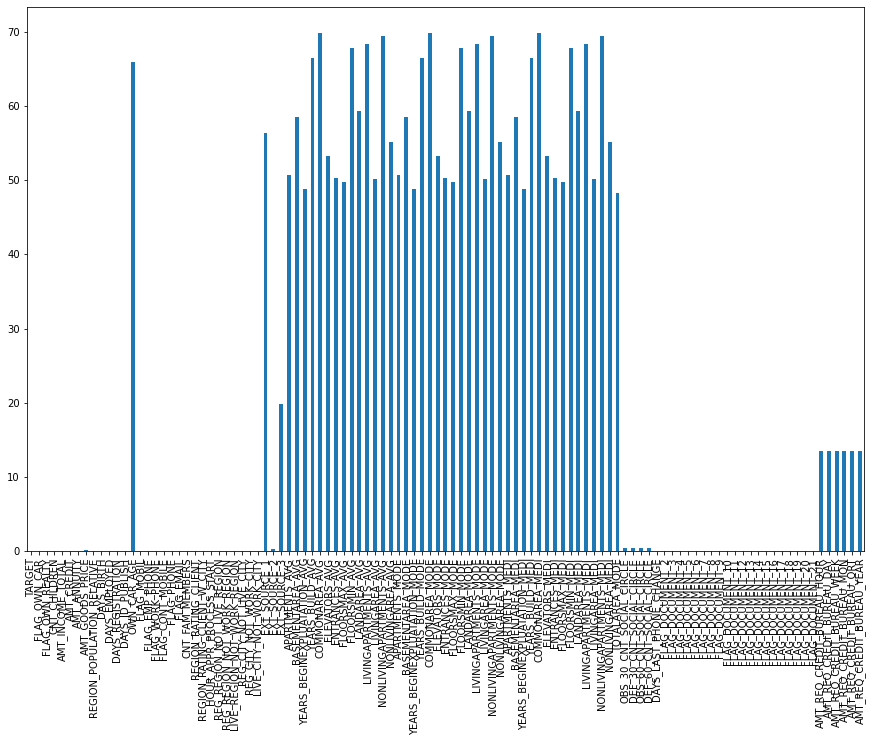

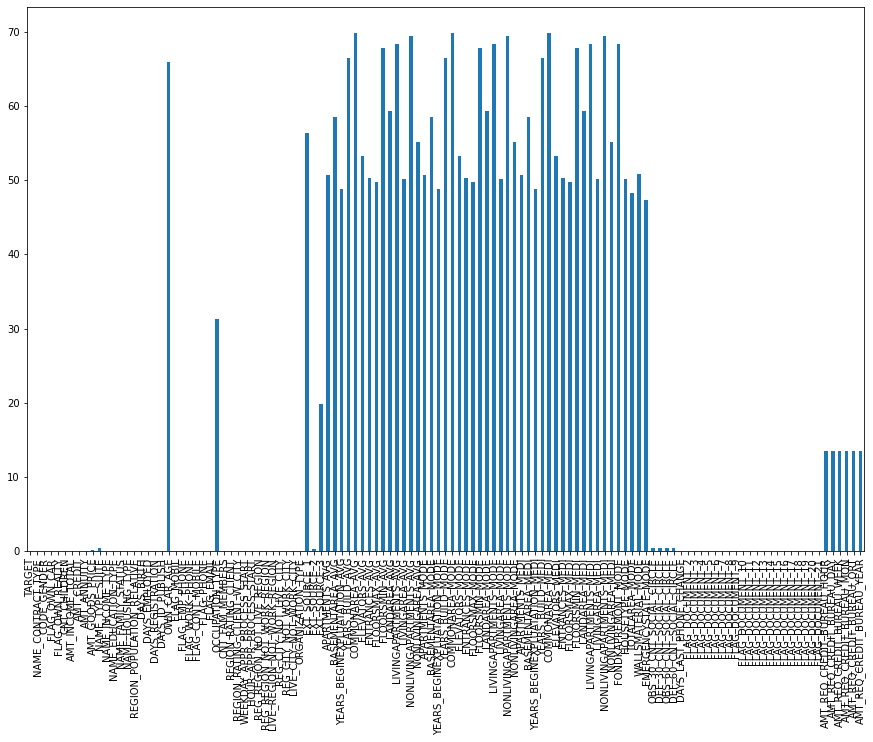

In [21]:
#liste des variables quantitatives 
print(get_numerical_categorical(train)[0])
#bar plot des pourcentages des nan dans chaque variable
show_null_per_variable(train[get_numerical_categorical(train)[0]])
show_null_per_variable(train)

In [22]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,0.0,1.0,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-16036.995067,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,0.0,0.0,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16036.995067,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,1.0,1.0,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-16036.995067,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

['SK_ID_CURR', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGIN

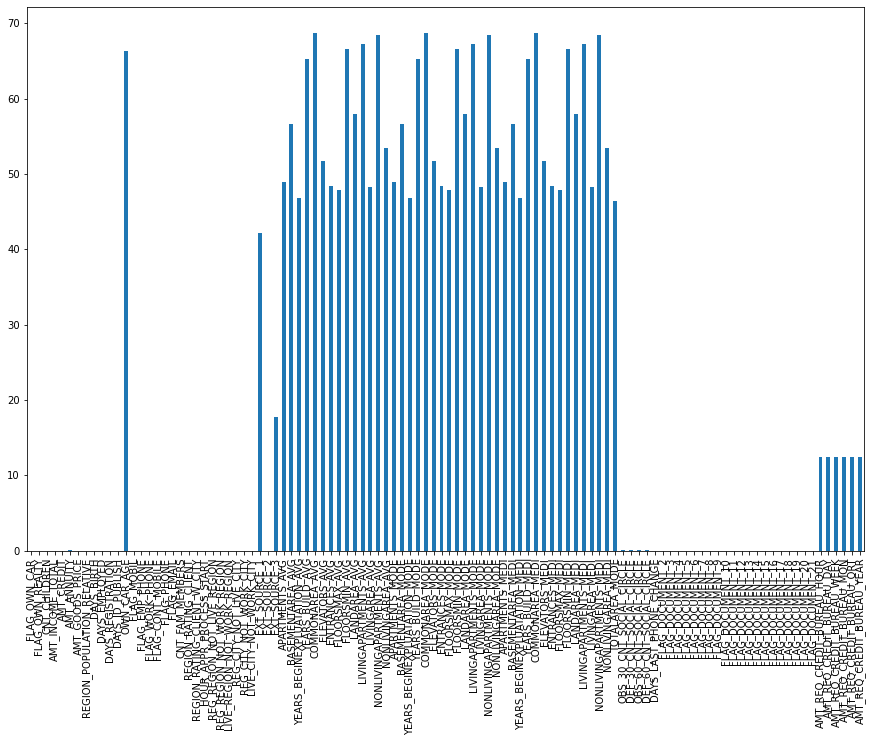

In [23]:
print(get_numerical_categorical(test)[0])
show_null_per_variable(test[get_numerical_categorical(test)[0]])

In [24]:
#variables numériques dans le dataframe
num_train_columns = get_numerical_categorical(train)[0]

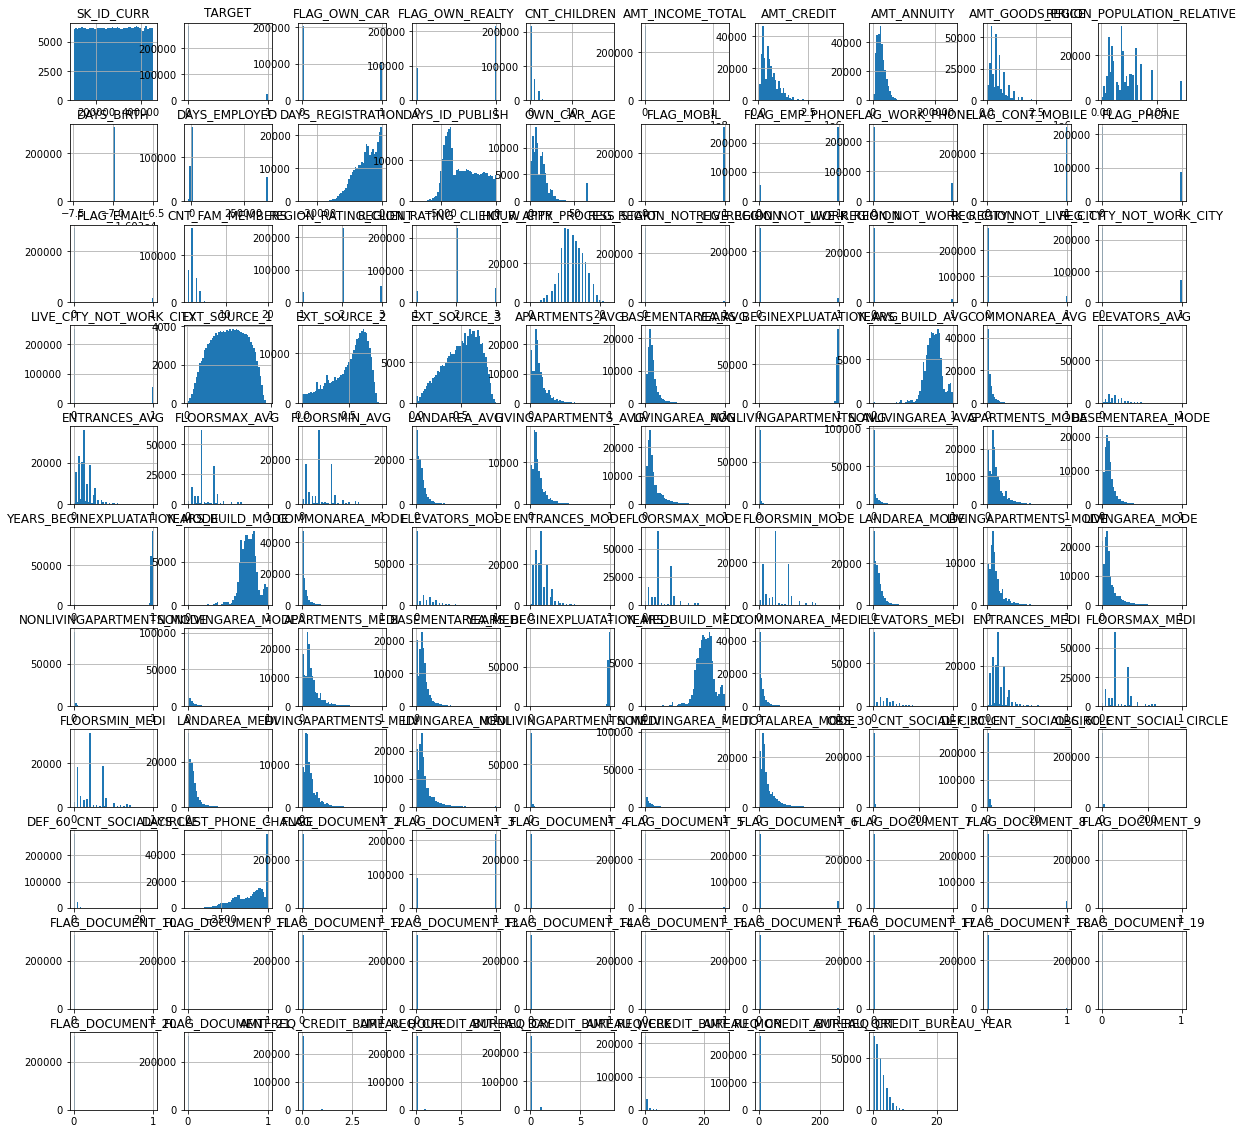

In [25]:
train[num_train_columns].hist(bins=50, figsize= (20,20))
plt.show()

In [26]:
#dans la variable OWN_CAR_AGE les personnes avec OWN_CAR = N ont des nan sur cette variable , on la remplace par -1
train['OWN_CAR_AGE'] = train['OWN_CAR_AGE'].fillna(-1)

In [27]:
train[num_train_columns].head()

,SK_ID_CURR,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0.0,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-16036.995067,-637,-3648.0,-2120,-1.0,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,0.0149,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0.0,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16036.995067,-1188,-1186.0,-291,-1.0,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,0.0714,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1.0,1.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-16036.995067,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0.0,1.0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-16036.995067,-3039,-9833.0,-2437,-1.0,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0.0,1.0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-16036.995067,-3038,-4311.0,-3458,-1.0,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,NaN,0

In [28]:
train.shape

(307511, 122)

In [29]:
#variables numériques dans le dataframe 
num_test_columns = get_numerical_categorical(test)[0]
print(num_test_columns)

['SK_ID_CURR', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGIN

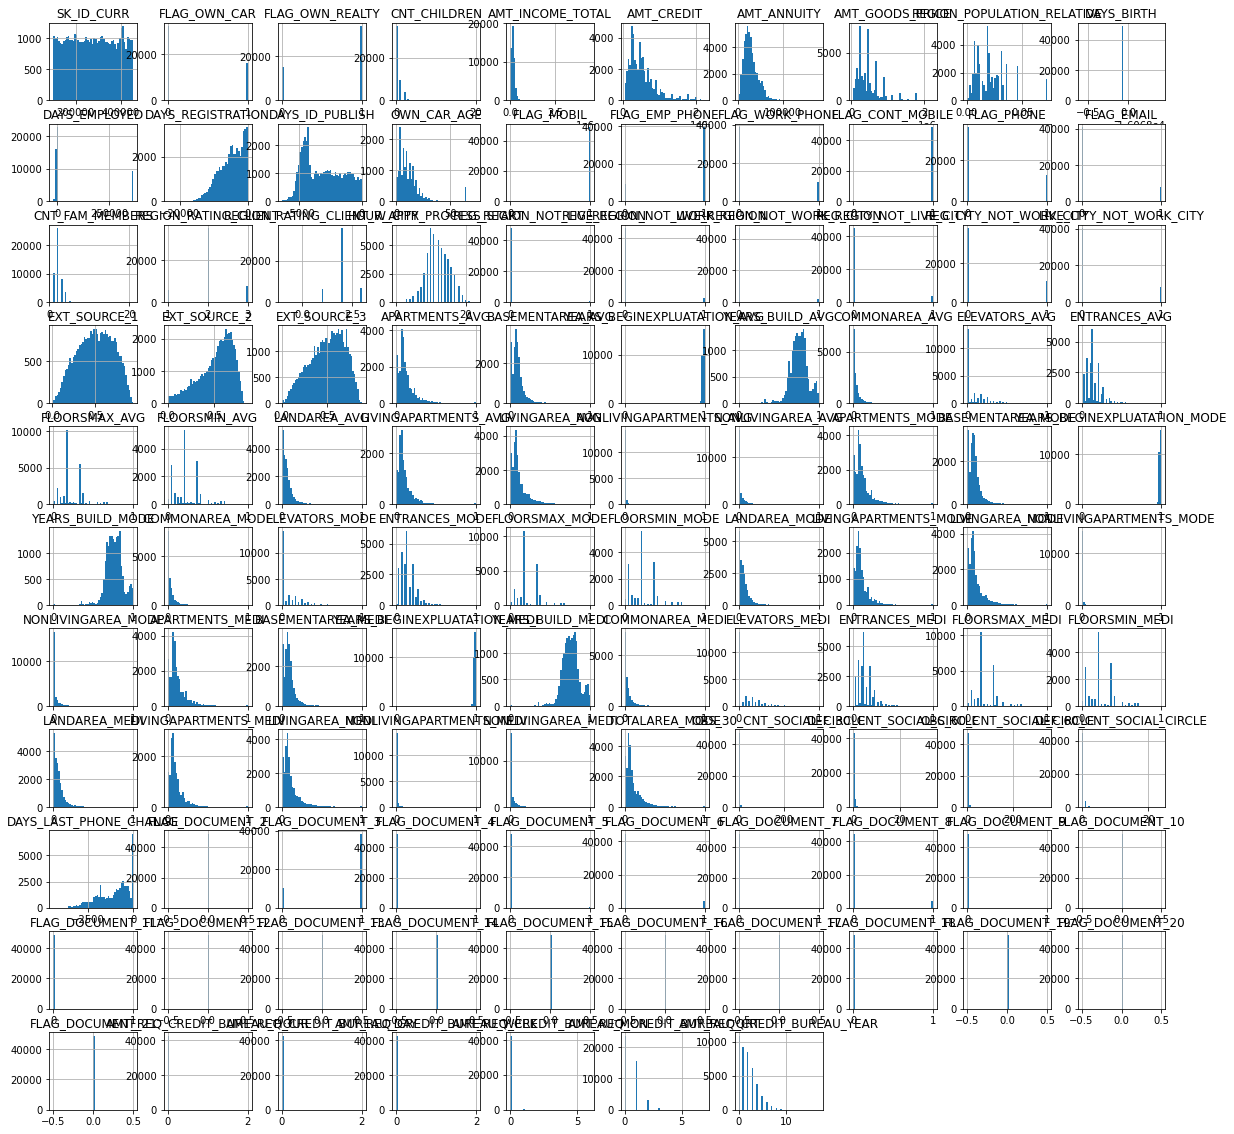

In [30]:
test[num_test_columns].hist(bins=50, figsize= (20,20))
plt.show()

In [31]:
# ces deux variables ne doivent pas subir une transformation (id non significatif comme nombre, target true ou false à ne pas transformer)
non_treated_columns = ['SK_ID_CURR', 'TARGET']

* Le test de Kolmogorov-Smirnov détermine si les observations d'un échantillon peuvent raisonnablement provenir d'une distribution théorique donnée (dont la loi normale)
* Il mesure de l'écart maximum qui existe entre la fonction de répartition observée (ou tout simplement des fréquences cumulées) et la fonction de répartition théorique (normale). 


In [32]:
# test de normalité avec kolmogorove smirnov nous permet de garder les variables non gaussienne et donc appliquer log dessus 
cols_log_trans_train = get_non_normal_ditributions_columns (train[num_train_columns].fillna(0), non_treated_columns)

In [33]:
null_ratio(train)

Valeurs nulles: 8949536
Valeurs non nulles : 28566806
Pourcentage des valeurs nulles : 23.855033627745478%


In [34]:
print(cols_log_trans_train)

['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_M

In [35]:
#jointure entre table test et table sample 
test = test.merge(df_sample_submission, on = ['SK_ID_CURR'], how = 'left')

In [36]:
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
0,100001,Cash loans,F,0.0,1.0,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-16068.084605,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
1,100005,Cash loans,M,0.0,1.0,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-16068.084605,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,0.5
2,100013,Cash loans,M,1.0,1.0,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-16068.084605,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0,0.5
3,100028,Cash loans,F,0.0,1.0,2,315000.0,1575000.0,49018.5,1575000.0,Una

In [37]:
cols_log_trans_test = get_non_normal_ditributions_columns (test[num_test_columns], non_treated_columns)

In [38]:
test[cols_log_trans_test].head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,0.0,1.0,0,135000.0,568800.0,450000.0,0.018850,-16068.084605,-2329,-5170.0,-812,1,1,0,1,0,1,2.0,2,2,18,0,0,0,0,0,0,0.789654,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,1.0,0,99000.0,222768.0,180000.0,0.035792,-16068.084605,-4469,-9118.0,-1623,1,1,0,1,0,0,2.0,2,2,9,0,0,0,0,0,0,0.291656,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1.0,0,202500.0,663264.0,630000.0,0.019101,-16068.084605,-4458,-2175.0,-3503,1,1,0,1,0,0,2.0,2,2,14,0,0,0,0,0,0,0.699787,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,1.0,2,315000.0,1575000.0,1575000.0,0.026392,-16068.084605,-1866,-2000.0,-4208,1,1,0,1,1,0,4.0,2,2,11,0,0,0,0,0,0,0.509677,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,1,180000.0,625500.0,625500.0,0.010032,-16068.084605,-2191,-4000.0,-4262,1,1,1,1,0,0,3.0,2,2,5,0,0,0,0,1,1,0.425687,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
# eliminer les variables qui sont en relation avec des détails de l'habitaton du clienthousin_details
housing_details_list = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 
'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG',
'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 
'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE',
'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 
'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 
'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 
'TOTALAREA_MODE']
#, 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE','FONDKAPREMONT_MODE','EMERGENCYSTATE_MODE'
train = train.drop(housing_details_list, axis=1)
test = test.drop(housing_details_list, axis=1)

In [40]:
print(train.shape)
print(test.shape)

(307511, 79)
(48744, 79)


In [41]:
print(train.columns)

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'FONDK

In [42]:
cat_train_columns = get_numerical_categorical(train)[1]
cat_test_columns = get_numerical_categorical(test)[1]

In [43]:
for c in cat_train_columns :
    uniques = train[c].unique()
    print (c + str(len(uniques)))
    print (uniques)
    

NAME_CONTRACT_TYPE2
['Cash loans' 'Revolving loans']
CODE_GENDER3
['M' 'F' 'XNA']
NAME_TYPE_SUITE8
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
NAME_INCOME_TYPE8
['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
NAME_EDUCATION_TYPE5
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS6
['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
NAME_HOUSING_TYPE6
['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
OCCUPATION_TYPE19
['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'IT sta

In [44]:
train_1= train.copy()
test_1 = test.copy()
train_1 = train_1.dropna()
test_1 = test_1.dropna()
print(train_1.shape)
print(test_1.shape)


(27283, 79)
(2125, 79)


In [45]:
del test_1, train_1
gc.collect()

40

In [46]:
for c in cat_test_columns :
    uniques = test[c].unique()
    print (c + str(len(uniques)))
    print (uniques)
   

NAME_CONTRACT_TYPE2
['Cash loans' 'Revolving loans']
CODE_GENDER2
['F' 'M']
NAME_TYPE_SUITE8
['Unaccompanied' nan 'Family' 'Spouse, partner' 'Group of people'
 'Other_B' 'Children' 'Other_A']
NAME_INCOME_TYPE7
['Working' 'State servant' 'Pensioner' 'Commercial associate'
 'Businessman' 'Student' 'Unemployed']
NAME_EDUCATION_TYPE5
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS5
['Married' 'Single / not married' 'Civil marriage' 'Widow' 'Separated']
NAME_HOUSING_TYPE6
['House / apartment' 'With parents' 'Rented apartment'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
OCCUPATION_TYPE19
[nan 'Low-skill Laborers' 'Drivers' 'Sales staff' 'High skill tech staff'
 'Core staff' 'Laborers' 'Managers' 'Accountants' 'Medicine staff'
 'Security staff' 'Private service staff' 'Secretaries' 'Cleaning staff'
 'Cooking staff' 'HR staff' 'Waiters/barmen staff' 'Realty agents'
 'IT staff']
WEEKDAY_APPR_PROCES

In [47]:
train['NAME_TYPE_SUITE']  = train['NAME_TYPE_SUITE'].replace([np.nan], 'Other_A')
train['OCCUPATION_TYPE'] = train['OCCUPATION_TYPE'].replace([np.nan], 'Other')
test['NAME_TYPE_SUITE'] = test['NAME_TYPE_SUITE'].replace([np.nan], 'Other_A')
test['OCCUPATION_TYPE'] = test['OCCUPATION_TYPE'].replace([np.nan], 'Other')

In [48]:
null_ratio(train)
null_ratio(test)

Valeurs nulles: 1155182
Valeurs non nulles : 23138187
Pourcentage des valeurs nulles : 4.755132974763607%
Valeurs nulles: 200472
Valeurs non nulles : 3650304
Pourcentage des valeurs nulles : 5.206015618670107%


In [49]:
NAME_TYPE_SUITE_dict= {"ALONE" : ['Unaccompanied'], 
                    "FAMILY" :  ['Family' ,'Spouse, partner' ,  'Children'], 
                    "OTHER" :  ['Other_A', 'Other_B', 'Group of people']} 

OCCUPATION_TYPE_dict = {5 : ['High skill tech staff', 'Medicine staff'], 
                    4 :  ['Accountants' , 'Managers', 'Realty agents', 'IT staff' ], 
                    3 :  ['Secretaries', 'HR staff', 'Private service staff', 'Sales staff' ],
                    2 :  [ 'Drivers' , 'Core staff', 'Laborers' , 'Security staff' ,  'Cleaning staff'],
                    1 :  ['Cooking staff' , 'Waiters/barmen staff' ],
                    0 :  ['Low-skill Laborers']} 

WEEKDAY_APPR_PROCESS_START_dict = {"WEED" : ['TUESDAY', 'FRIDAY', 'MONDAY', 'WEDNESDAY', 'THURSDAY'], 
                                    "WEEKEND" :  ['SATURDAY', 'SUNDAY']} 


#dict_list = [NAME_TYPE_SUITE_dict, OCCUPATION_TYPE_dict, WEEKDAY_APPR_PROCESS_START_dict, ORGANIZATION_TYPE_dict]
dict_list = [NAME_TYPE_SUITE_dict, OCCUPATION_TYPE_dict, WEEKDAY_APPR_PROCESS_START_dict]
unify(train, dict_list)
unify(test, dict_list)

NAME_TYPE_SUITE_dict
NAME_TYPE_SUITE
OCCUPATION_TYPE_dict
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START_dict
WEEKDAY_APPR_PROCESS_START
NAME_TYPE_SUITE_dict
NAME_TYPE_SUITE
OCCUPATION_TYPE_dict
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START_dict
WEEKDAY_APPR_PROCESS_START


In [50]:
print(cat_train_columns)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


In [51]:
print(cat_test_columns)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


In [52]:
print(train.shape)
null_ratio(train)

(307511, 79)
Valeurs nulles: 1155182
Valeurs non nulles : 23138187
Pourcentage des valeurs nulles : 4.755132974763607%


In [53]:
print(test.shape)
null_ratio(test)

(48744, 79)
Valeurs nulles: 200472
Valeurs non nulles : 3650304
Pourcentage des valeurs nulles : 5.206015618670107%


In [54]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,0.0,1.0,0,202500.0,406597.5,24700.5,351000.0,ALONE,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-16036.995067,-637,-3648.0,-2120,-1.0,1,1,0,1,1,0,2,1.0,2,2,WEED,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,reg oper account,block of flats,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,0.0,0.0,0,270000.0,1293502.5,35698.5,1129500.0,FAMILY,State servant,Higher education,Married,House / apartment,0.003541,-16036.995067,-1188,-1186.0,-291,-1.0,1,1,0,1,1,0,2,2.0,1,1,WEED,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,reg oper account,block of flats,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,1.0,1.0,0,67500.0,135000.0,6750.0,135000.0,ALONE,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-16036.995067,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,2,1.0,2,2,WEED,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,0.0,1.0,0,135000.0,312682.5,29686.5,297000.0,ALONE,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-16036.995067,-3039,-9833.0,-2437,-1.0,1,1,0,1,0,0,2,2.0,2,2,WEED,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,0.0,1.0,0,121500.0,513000.0,21865.5,513000.0,ALONE,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-16036.995067,-3038,-4311.0,-3458,-1.0,1,1,0,1,0,0,2,1.0,2,2,WEED,11,0,0,0,0,1,1,Religion,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
print(train.shape)
null_ratio(train)

(307511, 79)
Valeurs nulles: 1155182
Valeurs non nulles : 23138187
Pourcentage des valeurs nulles : 4.755132974763607%


In [56]:
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
0,100001,Cash loans,F,0.0,1.0,0,135000.0,568800.0,20560.5,450000.0,ALONE,Working,Higher education,Married,House / apartment,0.018850,-16068.084605,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,,2.0,2,2,WEED,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,NaN,block of flats,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
1,100005,Cash loans,M,0.0,1.0,0,99000.0,222768.0,17370.0,180000.0,ALONE,Working,Secondary / secondary special,Married,House / apartment,0.035792,-16068.084605,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,0,2.0,2,2,WEED,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,0.5
2,100013,Cash loans,M,1.0,1.0,0,202500.0,663264.0,69777.0,630000.0,OTHER,Working,Higher education,Married,House / apartment,0.019101,-16068.084605,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,2,2.0,2,2,WEED,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0,0.5
3,100028,Cash loans,F,0.0,1.0,2,315000.0,1575000.0,49018.5,1575000.0,ALONE,Working,Secondary / secondary special,Married,House / apartment,0.026392,-16068.084605,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,3,4.0,2,2,WEED,11,0,0,0,0,0,0,Business Entity Type 3,0.525734,0.509677,0.612704,reg oper account,block of flats,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,0.5
4,100038,Cash loans,M,1.0,0.0,1,180000.0,625500.0,32067.0,625500.0,ALONE,Working,Secondary / secondary special,Married,House / apartment,0.010032,-16068.084605,-2191,-4000.0,-4262,16.0,1,1,1,1,0,0,,3.0,2,2,WEED,5,0,0,0,0,1,1,Business Entity Type 3,0.202145,0.425687,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.5


In [57]:
train_1= train.copy()
test_1 = test.copy()
train_1 = train_1.dropna()
test_1 = test_1.dropna()
print(train_1.shape)
print(test_1.shape)


(36636, 79)
(2806, 79)


In [58]:
elements_ = [ele for ele in train if ele  not in test]
print(elements_)

[]


In [59]:
print(test.shape)
null_ratio(test)

(48744, 79)
Valeurs nulles: 200472
Valeurs non nulles : 3650304
Pourcentage des valeurs nulles : 5.206015618670107%


In [60]:
print(train.shape)
print(test.shape)

(307511, 79)
(48744, 79)


## Ingénierie des variable

In [61]:
df_bureau.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105273e+02,-1.017359e+03,3.825358e+03,6.410406e-03,3.545773e+05,1.370818e+05,6.229781e+03,3.791263e+01,-5.937483e+02,1.571327e+04
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.985500e+03,7.138443e+02,2.059873e+05,9.622391e-02,1.150277e+06,6.790749e+05,4.489666e+04,5.937519e+03,7.207473e+02,3.256556e+05
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08


In [62]:
df_bureau.head(3)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN


In [63]:
get_dtypes(df_bureau)

int32
int32
category
category
int64
int64
float32
float32
float32
int64
float32
float32
float32
float32
category
int64
float32


In [64]:
df_bureau.shape

(1716428, 17)

In [65]:
df_bureau_balance.describe()

,SK_ID_BUREAU,MONTHS_BALANCE
count,2.729992e+07,2.729992e+07
mean,6.036297e+06,-3.074169e+01
std,4.923489e+05,2.386451e+01
min,5.001709e+06,-9.600000e+01
25%,5.730933e+06,-4.600000e+01
50%,6.070821e+06,-2.500000e+01
75%,6.431951e+06,-1.100000e+01
max,6.842888e+06,0.000000e+00


In [66]:
df_bureau_balance.head(3)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C


In [67]:
df_bureau_balance.shape

(27299925, 3)

In [68]:
null_ratio(df_bureau_balance)

Valeurs nulles: 0
Valeurs non nulles : 81899775
Pourcentage des valeurs nulles : 0.0%


In [69]:
get_dtypes(df_bureau_balance)

int32
int64
category


In [70]:
#merge avec bureau_balance
df_bureau = df_bureau.merge(df_bureau_balance, on = ["SK_ID_BUREAU"], how = "left")
df_bureau['MIN_MONTH'] = df_bureau.groupby(['SK_ID_BUREAU'])['MONTHS_BALANCE'].transform('min')


In [71]:
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE,STATUS,MIN_MONTH
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN,NaN,NaN


In [72]:
df_bureau= df_bureau.drop(['MONTHS_BALANCE', 'STATUS'], axis =1)
df_bureau = df_bureau.drop_duplicates()
df_bureau.shape

(1716428, 18)

Valeurs nulles: 4882021
Valeurs non nulles : 26013683
Pourcentage des valeurs nulles : 15.80161759706139%


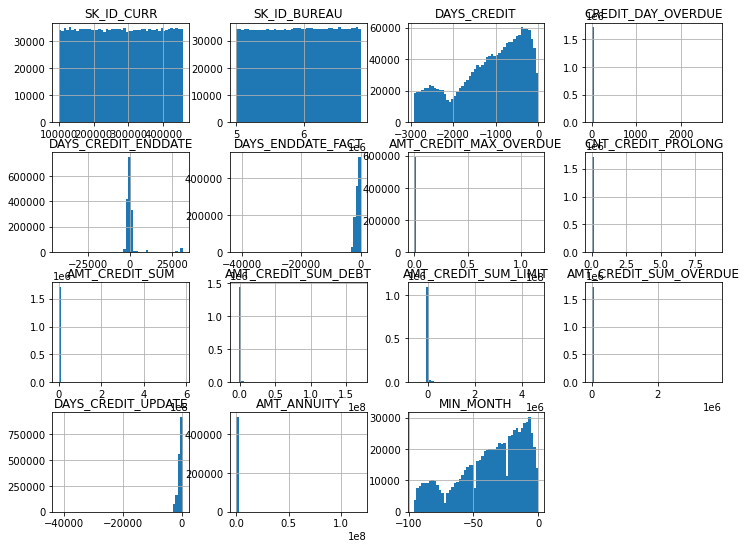

In [73]:
df_bureau = transform_flag_variables (df_bureau)
null_ratio(df_bureau)
#histogramme
df_bureau[get_numerical_categorical(df_bureau)[0]].hist(bins=50, figsize= (12,9))
plt.show()


In [74]:
B= df_bureau.copy()

In [75]:
# FEATURE 1 - NUMBER OF PAST LOANS PER CUSTOMER

grp = B[['SK_ID_CURR', 'DAYS_CREDIT']].groupby(by = ['SK_ID_CURR'])['DAYS_CREDIT'].count().reset_index().rename(index=str, columns={'DAYS_CREDIT': 'BUREAU_LOAN_COUNT'})
B = B.merge(grp, on = ['SK_ID_CURR'], how = 'left')
print(B.shape)

(1716428, 19)


In [76]:
B['BUREAU_LOAN_COUNT'].unique()

array([ 11,   6,   1,   8,   4,   2,  12,   5,  15,   7,  21,  17,   9,
         3,  16,  14,  13,  10,  18,  19,  20,  27,  32,  22,  29,  24,
        23,  40,  30,  25,  28,  31,  45,  26,  37,  33,  34,  54,  35,
        42,  41,  56,  47,  36, 116,  53,  38,  78,  58,  55,  51,  44,
        52,  57,  50,  60,  48,  39,  43,  49,  59,  61,  94,  46],
      dtype=int64)

In [77]:
# FEATURE 2 - NUMBER OF TYPES OF PAST LOANS PER CUSTOMER

#B = df_bureau.copy()
grp = B[['SK_ID_CURR', 'CREDIT_TYPE']].groupby(by = ['SK_ID_CURR'])['CREDIT_TYPE'].nunique().reset_index().rename(index=str, columns={'CREDIT_TYPE': 'BUREAU_LOAN_TYPES'})
B = B.merge(grp, on = ['SK_ID_CURR'], how = 'left')
print(B.shape)

(1716428, 20)


In [78]:
B['BUREAU_LOAN_TYPES'].unique()

array([3, 1, 2, 4, 5, 6], dtype=int64)

In [79]:
# FEATURE 3 - AVERAGE NUMBER OF PAST LOANS PER TYPE PER CUSTOMER
print(B.columns)
# Average Number of Loans per Loan Type
B['AVERAGE_LOAN_TYPE'] = B['BUREAU_LOAN_COUNT']/B['BUREAU_LOAN_TYPES']
del B['BUREAU_LOAN_COUNT'], B['BUREAU_LOAN_TYPES']

gc.collect()
print(B.shape)


Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY', 'MIN_MONTH', 'BUREAU_LOAN_COUNT', 'BUREAU_LOAN_TYPES'],
      dtype='object')
(1716428, 19)


In [80]:
print(B['AVERAGE_LOAN_TYPE' ].unique())

[ 3.66666667  2.          1.          4.          2.66666667  3.
  6.          2.5         7.5         3.5        10.5         8.5
  4.5         1.5         8.          7.          6.5         5.
  1.33333333 11.          3.33333333  6.33333333  1.66666667  9.
  5.66666667  5.5         2.33333333 10.          4.33333333 13.5
  4.66666667 10.66666667 13.          9.5         1.75       14.5
 12.          5.75        3.25        9.66666667 11.5         7.33333333
  7.66666667 15.         12.5        14.          2.25        6.66666667
  8.33333333 20.          4.25       15.5         3.75        5.33333333
 19.          2.75       16.          5.25       18.5        18.
  1.25       22.         17.          2.4         9.33333333  1.8
  6.75       16.5        27.          5.6        11.66666667  4.75
 17.5         8.66666667 21.         10.33333333 20.5        18.66666667
 25.         24.         11.75       38.66666667  2.8        26.5
 12.66666667 26.          2.2        22.5         2

In [81]:
B['AVERAGE_LOAN_TYPE' ].head(10)

0    3.666667
1    3.666667
2    3.666667
3    3.666667
4    3.666667
5    3.666667
6    3.666667
7    2.000000
8    2.000000
9    2.000000
Name: AVERAGE_LOAN_TYPE, dtype: float64

In [82]:
# FEATURE 4 - % OF ACTIVE LOANS FROM BUREAU DATA

# Create a new dummy column for whether CREDIT is ACTIVE OR CLOED 
B['CREDIT_ACTIVE_BINARY'] = B['CREDIT_ACTIVE']
B['CREDIT_ACTIVE_BINARY'] = B.apply(lambda x: convert_status(x.CREDIT_ACTIVE), axis = 1)

# Calculate mean number of loans that are ACTIVE per CUSTOMER 
grp = B.groupby(by = ['SK_ID_CURR'])['CREDIT_ACTIVE_BINARY'].mean().reset_index().rename(index=str, columns={'CREDIT_ACTIVE_BINARY': 'ACTIVE_LOANS_PERCENTAGE'})
B = B.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del B['CREDIT_ACTIVE_BINARY']
gc.collect()
print(B.shape)

(1716428, 20)


In [83]:
# FEATURE 5 AVERAGE NUMBER OF DAYS BETWEEN SUCCESSIVE PAST APPLICATIONS FOR EACH CUSTOMER

# Groupby each Customer and Sort values of DAYS_CREDIT in ascending order
grp = B[['SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_CREDIT']].groupby(by = ['SK_ID_CURR'])
grp1 = grp.apply(lambda x: x.sort_values(['DAYS_CREDIT'], ascending = False)).reset_index(drop = True)#rename(index = str, columns = {'DAYS_CREDIT': 'DAYS_CREDIT_DIFF'})
print("Grouping and Sorting done")

# Calculate Difference between the number of Days 
grp1['DAYS_CREDIT1'] = grp1['DAYS_CREDIT']*-1
grp1['DAYS_DIFF'] = grp1.groupby(by = ['SK_ID_CURR'])['DAYS_CREDIT1'].diff()
grp1['DAYS_DIFF'] = grp1['DAYS_DIFF'].fillna(0).astype('uint32')
del grp1['DAYS_CREDIT1'], grp1['DAYS_CREDIT'], grp1['SK_ID_CURR']
gc.collect()
print("Difference days calculated")

B = B.merge(grp1, on = ['SK_ID_BUREAU'], how = 'left')
print("Difference in Dates between Previous CB applications is CALCULATED ")
print(B.shape)

Grouping and Sorting done
Difference days calculated
Difference in Dates between Previous CB applications is CALCULATED 
(1716428, 21)


In [84]:
# FEATURE 6 % of LOANS PER CUSTOMER WHERE END DATE FOR CREDIT IS PAST

#B = df_bureau.copy()
B['CREDIT_ENDDATE_BINARY'] = B['DAYS_CREDIT_ENDDATE']
B['CREDIT_ENDDATE_BINARY'] = B.apply(lambda x: normalize(x.DAYS_CREDIT_ENDDATE), axis = 1)
print("New Binary Column calculated")

grp = B.groupby(by = ['SK_ID_CURR'])['CREDIT_ENDDATE_BINARY'].mean().reset_index().rename(index=str, columns={'CREDIT_ENDDATE_BINARY': 'CREDIT_ENDDATE_PERCENTAGE'})
B = B.merge(grp, on = ['SK_ID_CURR'], how = 'left')

del B['CREDIT_ENDDATE_BINARY']
gc.collect()
print(B.shape)

New Binary Column calculated
(1716428, 22)


In [85]:
print(B['CREDIT_ENDDATE_PERCENTAGE'].unique())
B['CREDIT_ENDDATE_PERCENTAGE'].head()



[0.54545455 0.16666667 1.         0.375      0.625      0.
 0.33333333 0.75       0.06666667 0.25       0.5        0.57142857
 0.35294118 0.22222222 0.2        0.125      0.44444444 0.85714286
 0.66666667 0.11111111 0.35714286 0.8        0.15384615 0.4
 0.6        0.27272727 0.42857143 0.28571429 0.18181818 0.83333333
 0.61538462 0.3        0.31578947 0.14285714 0.64705882 0.1
 0.71428571 0.7        0.45454545 0.38461538 0.58333333 0.09090909
 0.23076923 0.41666667 0.81818182 0.53333333 0.77777778 0.9
 0.27777778 0.36363636 0.21875    0.55555556 0.1875     0.46666667
 0.38888889 0.47368421 0.53846154 0.72727273 0.3125     0.27586207
 0.30769231 0.0625     0.47058824 0.6875     0.13333333 0.78571429
 0.42105263 0.58823529 0.91304348 0.88888889 0.65       0.63636364
 0.26666667 0.90909091 0.07692308 0.39130435 0.21428571 0.52631579
 0.46153846 0.23809524 0.41176471 0.47619048 0.21052632 0.07142857
 0.875      0.43478261 0.23333333 0.29411765 0.5625     0.23529412
 0.08333333 0.64       0

0    0.545455
1    0.545455
2    0.545455
3    0.545455
4    0.545455
Name: CREDIT_ENDDATE_PERCENTAGE, dtype: float64

In [86]:
# FEATURE 8 - DEBT OVER CREDIT RATIO

B[~B['AMT_CREDIT_SUM_LIMIT'].isnull()][0:2]

# WE can see in the Table Below 
# AMT_CREDIT_SUM = AMT_CREDIT_SUM_DEBT + AMT_CREDIT_SUM_LIMIT
#B = df_bureau.copy()

B['AMT_CREDIT_SUM_DEBT'] = B['AMT_CREDIT_SUM_DEBT'].fillna(0)
B['AMT_CREDIT_SUM'] = B['AMT_CREDIT_SUM'].fillna(0)

grp1 = B[['SK_ID_CURR', 'AMT_CREDIT_SUM_DEBT']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM_DEBT': 'TOTAL_CUSTOMER_DEBT'})
grp2 = B[['SK_ID_CURR', 'AMT_CREDIT_SUM']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM'].sum().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM': 'TOTAL_CUSTOMER_CREDIT'})

B = B.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
B = B.merge(grp2, on = ['SK_ID_CURR'], how = 'left')
del grp1, grp2
gc.collect()

B['DEBT_CREDIT_RATIO'] = B['TOTAL_CUSTOMER_DEBT']/B['TOTAL_CUSTOMER_CREDIT']

del B['TOTAL_CUSTOMER_DEBT'], B['TOTAL_CUSTOMER_CREDIT']
gc.collect()
print(B.shape)

(1716428, 23)


In [87]:
# FEATURE 9 - OVERDUE OVER DEBT RATIO

B['AMT_CREDIT_SUM_DEBT'] = B['AMT_CREDIT_SUM_DEBT'].fillna(0)
B['AMT_CREDIT_SUM_OVERDUE'] = B['AMT_CREDIT_SUM_OVERDUE'].fillna(0)

grp1 = B[['SK_ID_CURR', 'AMT_CREDIT_SUM_DEBT']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM_DEBT': 'TOTAL_CUSTOMER_DEBT'})
grp2 = B[['SK_ID_CURR', 'AMT_CREDIT_SUM_OVERDUE']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM_OVERDUE'].sum().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM_OVERDUE': 'TOTAL_CUSTOMER_OVERDUE'})

B = B.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
B = B.merge(grp2, on = ['SK_ID_CURR'], how = 'left')
del grp1, grp2
gc.collect()

B['OVERDUE_DEBT_RATIO'] = B['TOTAL_CUSTOMER_OVERDUE']/B['TOTAL_CUSTOMER_DEBT']

del B['TOTAL_CUSTOMER_OVERDUE'], B['TOTAL_CUSTOMER_DEBT']
gc.collect()
print(B.shape)

(1716428, 24)


In [88]:
# FEATURE 10 - AVERAGE NUMBER OF LOANS PROLONGED

B['CNT_CREDIT_PROLONG'] = B['CNT_CREDIT_PROLONG'].fillna(0)
grp = B[['SK_ID_CURR', 'CNT_CREDIT_PROLONG']].groupby(by = ['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index().rename( index = str, columns = { 'CNT_CREDIT_PROLONG': 'AVG_CREDITDAYS_PROLONGED'})
B = B.merge(grp, on = ['SK_ID_CURR'], how = 'left')
print(B.shape)

(1716428, 25)


In [89]:
df_credit_card_balance.describe()
to_keep_credit_balance = missing_percentage_variable(df_credit_card_balance, 70)
df_credit_card_balance = df_credit_card_balance[to_keep_credit_balance]

SK_ID_PREV > Missing values : 0 (0.0%)
SK_ID_CURR > Missing values : 0 (0.0%)
MONTHS_BALANCE > Missing values : 0 (0.0%)
AMT_BALANCE > Missing values : 0 (0.0%)
AMT_CREDIT_LIMIT_ACTUAL > Missing values : 0 (0.0%)
AMT_DRAWINGS_ATM_CURRENT > Missing values : 749816 (19.5%)
AMT_DRAWINGS_CURRENT > Missing values : 0 (0.0%)
AMT_DRAWINGS_OTHER_CURRENT > Missing values : 749816 (19.5%)
AMT_DRAWINGS_POS_CURRENT > Missing values : 749816 (19.5%)
AMT_INST_MIN_REGULARITY > Missing values : 305236 (7.9%)
AMT_PAYMENT_CURRENT > Missing values : 767988 (20.0%)
AMT_PAYMENT_TOTAL_CURRENT > Missing values : 0 (0.0%)
AMT_RECEIVABLE_PRINCIPAL > Missing values : 0 (0.0%)
AMT_RECIVABLE > Missing values : 0 (0.0%)
AMT_TOTAL_RECEIVABLE > Missing values : 0 (0.0%)
CNT_DRAWINGS_ATM_CURRENT > Missing values : 749816 (19.5%)
CNT_DRAWINGS_CURRENT > Missing values : 0 (0.0%)
CNT_DRAWINGS_OTHER_CURRENT > Missing values : 749816 (19.5%)
CNT_DRAWINGS_POS_CURRENT > Missing values : 749816 (19.5%)
CNT_INSTALMENT_MATURE_

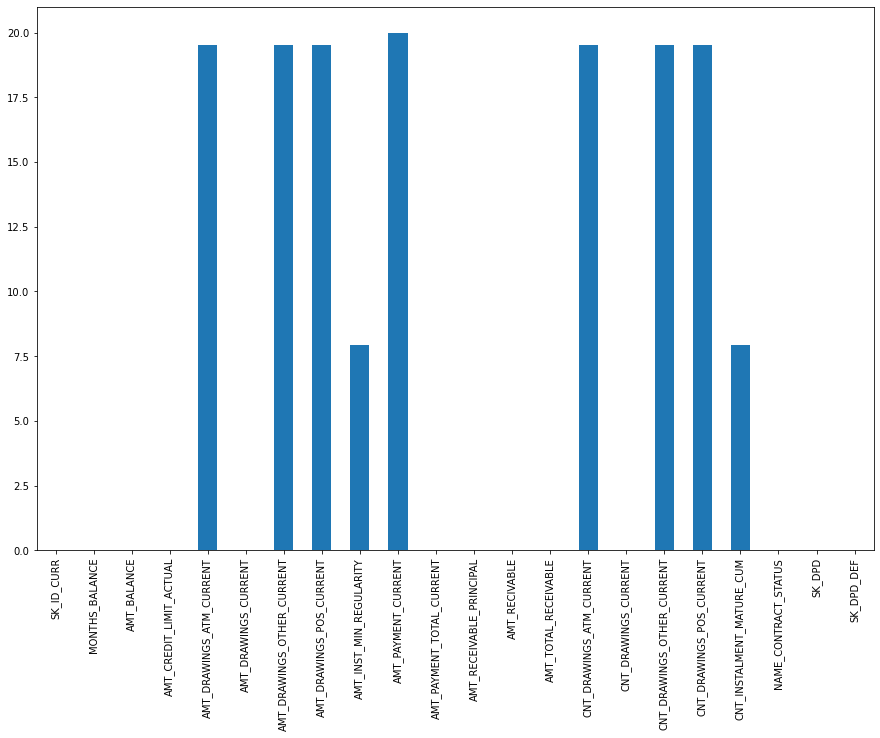

In [90]:
#show_null_per_variable(df_credit_card_balance[get_numerical_categorical(df_credit_card_balance)[0]])
show_null_per_variable(df_credit_card_balance)

In [91]:
df_credit_card_balance.head(3)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,1800.0,1800.0,0.000000,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,2250.0,2250.0,60175.078125,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,2250.0,2250.0,26926.425781,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0


In [92]:
null_ratio(df_credit_card_balance)

Valeurs nulles: 5877356
Valeurs non nulles : 82449820
Pourcentage des valeurs nulles : 6.654074392687479%


In [93]:
get_dtypes(df_credit_card_balance)

int32
int32
int64
float32
int64
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
int64
float32
float32
float32
category
int64
int64


In [94]:
df_credit_card_balance.shape

(3840312, 23)

Valeurs nulles: 5877356
Valeurs non nulles : 82449820
Pourcentage des valeurs nulles : 6.654074392687479%
Valeurs nulles: 5877356
Valeurs non nulles : 82449820
Pourcentage des valeurs nulles : 6.654074392687479%


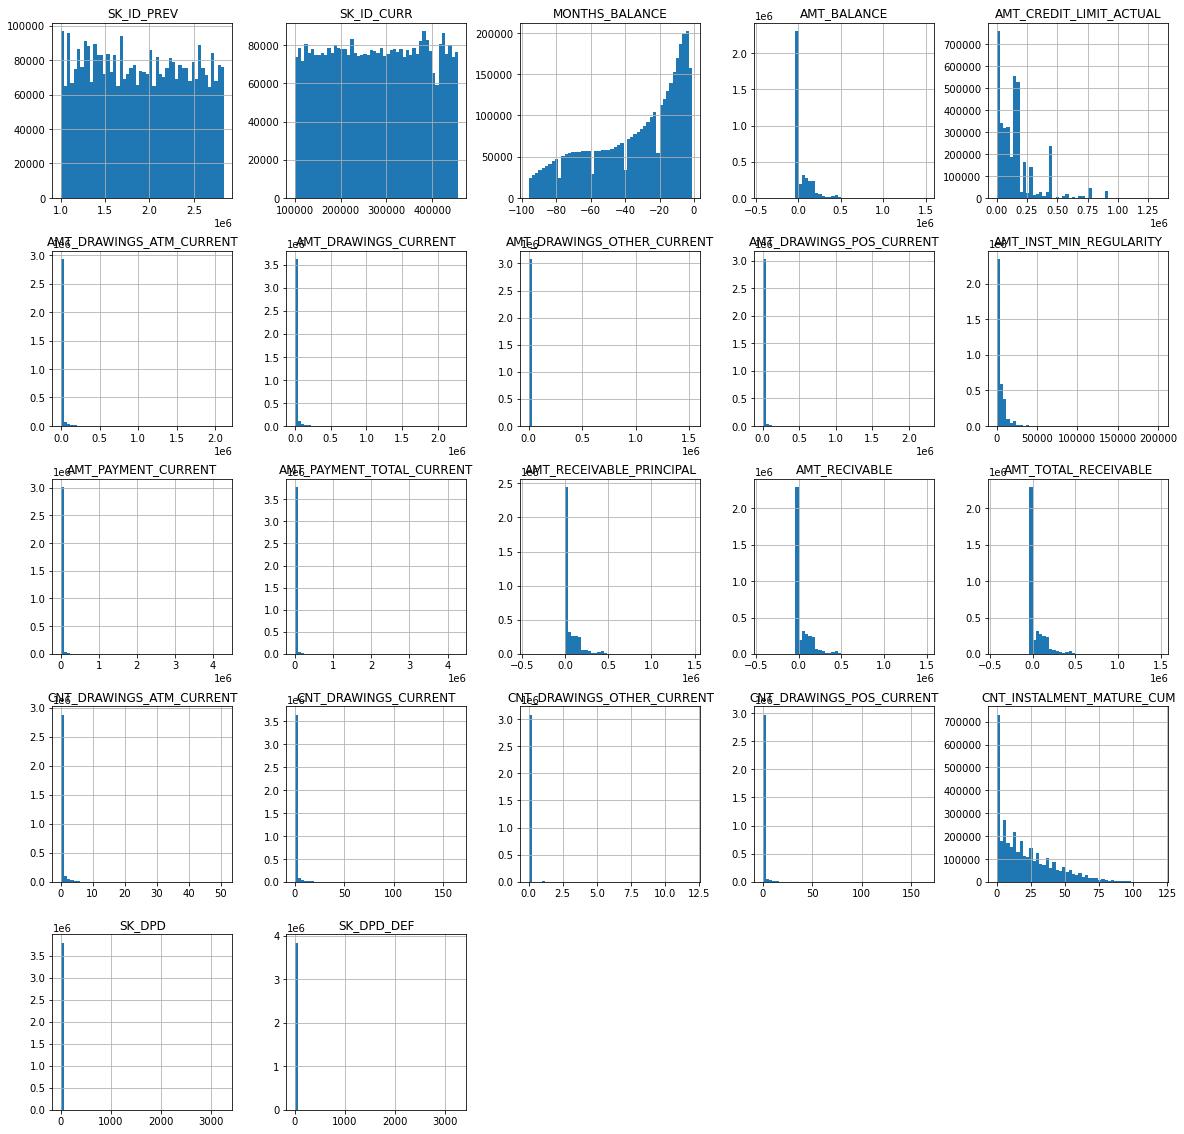

In [95]:
null_ratio(df_credit_card_balance)
df_credit_card_balance = transform_flag_variables (df_credit_card_balance)
null_ratio(df_credit_card_balance)
#histogrammes
df_credit_card_balance[get_numerical_categorical(df_credit_card_balance)[0]].hist(bins=50, figsize= (20,20))
plt.show()


In [96]:
get_dtypes(df_credit_card_balance)
cat_credit_cols = []
num=[]
for y in df_credit_card_balance.columns :
    if (df_credit_card_balance[y].dtype == numpy.float64 or df_credit_card_balance[y].dtype == numpy.int64 or df_credit_card_balance[y].dtype == numpy.float32 or df_credit_card_balance[y].dtype == numpy.int32) :
        num.append(y)
    else :
        cat_credit_cols.append(y)

int32
int32
int64
float32
int64
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
int64
float32
float32
float32
category
int64
int64


In [97]:
#FEATURE 1 - NUMBER OF LOANS PER CUSTOMER
CCB = df_credit_card_balance
grp = CCB.groupby(by = ['SK_ID_CURR'])['SK_ID_PREV'].nunique().reset_index().rename(index = str, columns = {'SK_ID_PREV': 'NO_LOANS'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
gc.collect()
print(CCB.dtypes, CCB.shape)

SK_ID_PREV                       int32
SK_ID_CURR                       int32
MONTHS_BALANCE                   int64
AMT_BALANCE                    float32
AMT_CREDIT_LIMIT_ACTUAL          int64
AMT_DRAWINGS_ATM_CURRENT       float32
AMT_DRAWINGS_CURRENT           float32
AMT_DRAWINGS_OTHER_CURRENT     float32
AMT_DRAWINGS_POS_CURRENT       float32
AMT_INST_MIN_REGULARITY        float32
AMT_PAYMENT_CURRENT            float32
AMT_PAYMENT_TOTAL_CURRENT      float32
AMT_RECEIVABLE_PRINCIPAL       float32
AMT_RECIVABLE                  float32
AMT_TOTAL_RECEIVABLE           float32
CNT_DRAWINGS_ATM_CURRENT       float32
CNT_DRAWINGS_CURRENT             int64
CNT_DRAWINGS_OTHER_CURRENT     float32
CNT_DRAWINGS_POS_CURRENT       float32
CNT_INSTALMENT_MATURE_CUM      float32
NAME_CONTRACT_STATUS          category
SK_DPD                           int64
SK_DPD_DEF                       int64
NO_LOANS                         int64
dtype: object (3840312, 24)


In [98]:
#FEATURE 2 - RATE OF PAYBACK OF LOANS - NO OF INSTALMENTS PAID BY CUSTOMER PER LOAN

# CNT_INSTALMENT_MATURE_CUM gives number of installments paid as of that month 
# The Max of this column shows the total number of installments made for that loan 
CCB = df_credit_card_balance[0:]
grp = CCB.groupby(by = ['SK_ID_CURR'])['SK_ID_PREV'].nunique().reset_index().rename(index = str, columns = {'SK_ID_PREV': 'NO_LOANS'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
gc.collect()

print(CCB.dtypes)


# No of Installments paid per Loan per Customer 

grp = CCB.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV'])['CNT_INSTALMENT_MATURE_CUM'].max().reset_index().rename(index = str, columns = {'CNT_INSTALMENT_MATURE_CUM': 'NO_INSTALMENTS'})
grp1 = grp.groupby(by = ['SK_ID_CURR'])['NO_INSTALMENTS'].sum().reset_index().rename(index = str, columns = {'NO_INSTALMENTS': 'TOTAL_INSTALMENTS'})
CCB = CCB.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
del grp, grp1
gc.collect()

# Average Number of installments paid per loan 

CCB['INSTALLMENTS_PER_LOAN'] = (CCB['TOTAL_INSTALMENTS']/CCB['NO_LOANS']).astype('uint32')
del CCB['TOTAL_INSTALMENTS']
del CCB['NO_LOANS']
gc.collect()

print(CCB.dtypes, CCB.shape)

SK_ID_PREV                       int32
SK_ID_CURR                       int32
MONTHS_BALANCE                   int64
AMT_BALANCE                    float32
AMT_CREDIT_LIMIT_ACTUAL          int64
AMT_DRAWINGS_ATM_CURRENT       float32
AMT_DRAWINGS_CURRENT           float32
AMT_DRAWINGS_OTHER_CURRENT     float32
AMT_DRAWINGS_POS_CURRENT       float32
AMT_INST_MIN_REGULARITY        float32
AMT_PAYMENT_CURRENT            float32
AMT_PAYMENT_TOTAL_CURRENT      float32
AMT_RECEIVABLE_PRINCIPAL       float32
AMT_RECIVABLE                  float32
AMT_TOTAL_RECEIVABLE           float32
CNT_DRAWINGS_ATM_CURRENT       float32
CNT_DRAWINGS_CURRENT             int64
CNT_DRAWINGS_OTHER_CURRENT     float32
CNT_DRAWINGS_POS_CURRENT       float32
CNT_INSTALMENT_MATURE_CUM      float32
NAME_CONTRACT_STATUS          category
SK_DPD                           int64
SK_DPD_DEF                       int64
NO_LOANS                         int64
dtype: object
SK_ID_PREV                       int32
SK_ID_CURR 

In [99]:
#FEATURE 3 - AVG % LOADING OF CREDIT LIMIT PER CUSTOMER : HOW BADLY DID THE CUSTOMER NEED THE LOAN?

CCB['AMT_CREDIT_LIMIT_ACTUAL1'] = CCB['AMT_CREDIT_LIMIT_ACTUAL']

# Calculate the ratio of Amount Balance to Credit Limit - CREDIT LOAD OF CUSTOMER 
# This is done for each Credit limit value per loan per Customer 

grp = CCB.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV', 'AMT_CREDIT_LIMIT_ACTUAL']).apply(lambda x: balance_limit(x.AMT_BALANCE, x.AMT_CREDIT_LIMIT_ACTUAL1)).reset_index().rename(index = str, columns = {0: 'CREDIT_LOAD1'})
del CCB['AMT_CREDIT_LIMIT_ACTUAL1']
gc.collect()

# We now calculate the mean Credit load of All Loan transactions of Customer 
grp1 = grp.groupby(by = ['SK_ID_CURR'])['CREDIT_LOAD1'].mean().reset_index().rename(index = str, columns = {'CREDIT_LOAD1': 'CREDIT_LOAD'})
print(grp1.dtypes)

CCB = CCB.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
del grp, grp1
gc.collect()

print(CCB.dtypes, CCB.shape)

SK_ID_CURR       int64
CREDIT_LOAD    float64
dtype: object
SK_ID_PREV                       int32
SK_ID_CURR                       int32
MONTHS_BALANCE                   int64
AMT_BALANCE                    float32
AMT_CREDIT_LIMIT_ACTUAL          int64
AMT_DRAWINGS_ATM_CURRENT       float32
AMT_DRAWINGS_CURRENT           float32
AMT_DRAWINGS_OTHER_CURRENT     float32
AMT_DRAWINGS_POS_CURRENT       float32
AMT_INST_MIN_REGULARITY        float32
AMT_PAYMENT_CURRENT            float32
AMT_PAYMENT_TOTAL_CURRENT      float32
AMT_RECEIVABLE_PRINCIPAL       float32
AMT_RECIVABLE                  float32
AMT_TOTAL_RECEIVABLE           float32
CNT_DRAWINGS_ATM_CURRENT       float32
CNT_DRAWINGS_CURRENT             int64
CNT_DRAWINGS_OTHER_CURRENT     float32
CNT_DRAWINGS_POS_CURRENT       float32
CNT_INSTALMENT_MATURE_CUM      float32
NAME_CONTRACT_STATUS          category
SK_DPD                           int64
SK_DPD_DEF                       int64
INSTALLMENTS_PER_LOAN           uint32
CRED

In [100]:
#FEATURE 4 - AVERAGE NUMBER OF TIMES DAYS PAST DUE HAS OCCURRED PER CUSTOMER
# Function to calculate number of times Days Past Due occurred 

grp = CCB.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV']).apply(lambda x: DPD(x.SK_DPD)).reset_index().rename(index = str, columns = {0: 'NO_DPD'})
grp1 = grp.groupby(by = ['SK_ID_CURR'])['NO_DPD'].mean().reset_index().rename(index = str, columns = {'NO_DPD' : 'DPD_COUNT'})

CCB = CCB.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
del grp1
del grp 
gc.collect()

print(CCB.dtypes, CCB.shape)

SK_ID_PREV                       int32
SK_ID_CURR                       int32
MONTHS_BALANCE                   int64
AMT_BALANCE                    float32
AMT_CREDIT_LIMIT_ACTUAL          int64
AMT_DRAWINGS_ATM_CURRENT       float32
AMT_DRAWINGS_CURRENT           float32
AMT_DRAWINGS_OTHER_CURRENT     float32
AMT_DRAWINGS_POS_CURRENT       float32
AMT_INST_MIN_REGULARITY        float32
AMT_PAYMENT_CURRENT            float32
AMT_PAYMENT_TOTAL_CURRENT      float32
AMT_RECEIVABLE_PRINCIPAL       float32
AMT_RECIVABLE                  float32
AMT_TOTAL_RECEIVABLE           float32
CNT_DRAWINGS_ATM_CURRENT       float32
CNT_DRAWINGS_CURRENT             int64
CNT_DRAWINGS_OTHER_CURRENT     float32
CNT_DRAWINGS_POS_CURRENT       float32
CNT_INSTALMENT_MATURE_CUM      float32
NAME_CONTRACT_STATUS          category
SK_DPD                           int64
SK_DPD_DEF                       int64
INSTALLMENTS_PER_LOAN           uint32
CREDIT_LOAD                    float64
DPD_COUNT                

In [101]:
#FEATURE 5 - AVERAGE OF DAYS PAST DUE PER CUSTOMER

grp = CCB.groupby(by= ['SK_ID_CURR'])['SK_DPD'].mean().reset_index().rename(index = str, columns = {'SK_DPD': 'AVG_DPD'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
gc.collect()

print(CCB.dtypes, CCB.shape)

SK_ID_PREV                       int32
SK_ID_CURR                       int32
MONTHS_BALANCE                   int64
AMT_BALANCE                    float32
AMT_CREDIT_LIMIT_ACTUAL          int64
AMT_DRAWINGS_ATM_CURRENT       float32
AMT_DRAWINGS_CURRENT           float32
AMT_DRAWINGS_OTHER_CURRENT     float32
AMT_DRAWINGS_POS_CURRENT       float32
AMT_INST_MIN_REGULARITY        float32
AMT_PAYMENT_CURRENT            float32
AMT_PAYMENT_TOTAL_CURRENT      float32
AMT_RECEIVABLE_PRINCIPAL       float32
AMT_RECIVABLE                  float32
AMT_TOTAL_RECEIVABLE           float32
CNT_DRAWINGS_ATM_CURRENT       float32
CNT_DRAWINGS_CURRENT             int64
CNT_DRAWINGS_OTHER_CURRENT     float32
CNT_DRAWINGS_POS_CURRENT       float32
CNT_INSTALMENT_MATURE_CUM      float32
NAME_CONTRACT_STATUS          category
SK_DPD                           int64
SK_DPD_DEF                       int64
INSTALLMENTS_PER_LOAN           uint32
CREDIT_LOAD                    float64
DPD_COUNT                

In [102]:
#FEATURE 6 - % of MINIMUM PAYMENTS MISSED

grp = CCB.groupby(by = ['SK_ID_CURR']).apply(lambda x: count_transaction(x.AMT_INST_MIN_REGULARITY, x.AMT_PAYMENT_CURRENT)).reset_index().rename(index = str, columns = { 0 : 'PERCENTAGE_MISSED_PAYMENTS'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
gc.collect()

print(CCB.dtypes, CCB.shape)

SK_ID_PREV                       int32
SK_ID_CURR                       int32
MONTHS_BALANCE                   int64
AMT_BALANCE                    float32
AMT_CREDIT_LIMIT_ACTUAL          int64
AMT_DRAWINGS_ATM_CURRENT       float32
AMT_DRAWINGS_CURRENT           float32
AMT_DRAWINGS_OTHER_CURRENT     float32
AMT_DRAWINGS_POS_CURRENT       float32
AMT_INST_MIN_REGULARITY        float32
AMT_PAYMENT_CURRENT            float32
AMT_PAYMENT_TOTAL_CURRENT      float32
AMT_RECEIVABLE_PRINCIPAL       float32
AMT_RECIVABLE                  float32
AMT_TOTAL_RECEIVABLE           float32
CNT_DRAWINGS_ATM_CURRENT       float32
CNT_DRAWINGS_CURRENT             int64
CNT_DRAWINGS_OTHER_CURRENT     float32
CNT_DRAWINGS_POS_CURRENT       float32
CNT_INSTALMENT_MATURE_CUM      float32
NAME_CONTRACT_STATUS          category
SK_DPD                           int64
SK_DPD_DEF                       int64
INSTALLMENTS_PER_LOAN           uint32
CREDIT_LOAD                    float64
DPD_COUNT                

In [103]:
#FEATURE 7 - RATIO OF CASH VS CARD SWIPES
#IF A CUSTOMER IS USING CREDIT CARDS FOR CASH WITHDRAWALS - IS IT A RED FLAG ??


grp = CCB.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_ATM_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_ATM_CURRENT' : 'DRAWINGS_ATM'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp
gc.collect()

grp = CCB.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_CURRENT' : 'DRAWINGS_TOTAL'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp
gc.collect()

CCB['CASH_CARD_RATIO1'] = (CCB['DRAWINGS_ATM']/CCB['DRAWINGS_TOTAL'])*100
del CCB['DRAWINGS_ATM']
del CCB['DRAWINGS_TOTAL']
gc.collect()

grp = CCB.groupby(by = ['SK_ID_CURR'])['CASH_CARD_RATIO1'].mean().reset_index().rename(index = str, columns ={ 'CASH_CARD_RATIO1' : 'CASH_CARD_RATIO'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
gc.collect()

del CCB['CASH_CARD_RATIO1']
gc.collect()

print(CCB.dtypes, CCB.shape)

# WE can leave NaN values as they are for LGBM 

SK_ID_PREV                       int32
SK_ID_CURR                       int32
MONTHS_BALANCE                   int64
AMT_BALANCE                    float32
AMT_CREDIT_LIMIT_ACTUAL          int64
AMT_DRAWINGS_ATM_CURRENT       float32
AMT_DRAWINGS_CURRENT           float32
AMT_DRAWINGS_OTHER_CURRENT     float32
AMT_DRAWINGS_POS_CURRENT       float32
AMT_INST_MIN_REGULARITY        float32
AMT_PAYMENT_CURRENT            float32
AMT_PAYMENT_TOTAL_CURRENT      float32
AMT_RECEIVABLE_PRINCIPAL       float32
AMT_RECIVABLE                  float32
AMT_TOTAL_RECEIVABLE           float32
CNT_DRAWINGS_ATM_CURRENT       float32
CNT_DRAWINGS_CURRENT             int64
CNT_DRAWINGS_OTHER_CURRENT     float32
CNT_DRAWINGS_POS_CURRENT       float32
CNT_INSTALMENT_MATURE_CUM      float32
NAME_CONTRACT_STATUS          category
SK_DPD                           int64
SK_DPD_DEF                       int64
INSTALLMENTS_PER_LOAN           uint32
CREDIT_LOAD                    float64
DPD_COUNT                

In [104]:
# FEATURE 8 - AVERAGE DRAWING PER CUSTOMER

grp = CCB.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_CURRENT' : 'TOTAL_DRAWINGS'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp
gc.collect()

grp = CCB.groupby(by = ['SK_ID_CURR'])['CNT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'CNT_DRAWINGS_CURRENT' : 'NO_DRAWINGS'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp
gc.collect()

CCB['DRAWINGS_RATIO1'] = (CCB['TOTAL_DRAWINGS']/CCB['NO_DRAWINGS'])*100
del CCB['TOTAL_DRAWINGS']
del CCB['NO_DRAWINGS']
gc.collect()

grp = CCB.groupby(by = ['SK_ID_CURR'])['DRAWINGS_RATIO1'].mean().reset_index().rename(index = str, columns ={ 'DRAWINGS_RATIO1' : 'DRAWINGS_RATIO'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
gc.collect()

del CCB['DRAWINGS_RATIO1']

print(CCB.dtypes, CCB.shape)

SK_ID_PREV                       int32
SK_ID_CURR                       int32
MONTHS_BALANCE                   int64
AMT_BALANCE                    float32
AMT_CREDIT_LIMIT_ACTUAL          int64
AMT_DRAWINGS_ATM_CURRENT       float32
AMT_DRAWINGS_CURRENT           float32
AMT_DRAWINGS_OTHER_CURRENT     float32
AMT_DRAWINGS_POS_CURRENT       float32
AMT_INST_MIN_REGULARITY        float32
AMT_PAYMENT_CURRENT            float32
AMT_PAYMENT_TOTAL_CURRENT      float32
AMT_RECEIVABLE_PRINCIPAL       float32
AMT_RECIVABLE                  float32
AMT_TOTAL_RECEIVABLE           float32
CNT_DRAWINGS_ATM_CURRENT       float32
CNT_DRAWINGS_CURRENT             int64
CNT_DRAWINGS_OTHER_CURRENT     float32
CNT_DRAWINGS_POS_CURRENT       float32
CNT_INSTALMENT_MATURE_CUM      float32
NAME_CONTRACT_STATUS          category
SK_DPD                           int64
SK_DPD_DEF                       int64
INSTALLMENTS_PER_LOAN           uint32
CREDIT_LOAD                    float64
DPD_COUNT                

In [105]:
df_installments_payments.describe()
to_keep_installment = missing_percentage_variable(df_installments_payments, 70)
df_installments_payments = df_installments_payments[to_keep_installment]

SK_ID_PREV > Missing values : 0 (0.0%)
SK_ID_CURR > Missing values : 0 (0.0%)
NUM_INSTALMENT_VERSION > Missing values : 0 (0.0%)
NUM_INSTALMENT_NUMBER > Missing values : 0 (0.0%)
DAYS_INSTALMENT > Missing values : 0 (0.0%)
DAYS_ENTRY_PAYMENT > Missing values : 2905 (0.0%)
AMT_INSTALMENT > Missing values : 0 (0.0%)
AMT_PAYMENT > Missing values : 2905 (0.0%)


In [106]:
df_installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [107]:
null_ratio(df_installments_payments)

Valeurs nulles: 5810
Valeurs non nulles : 108837398
Pourcentage des valeurs nulles : 0.005337953655316738%


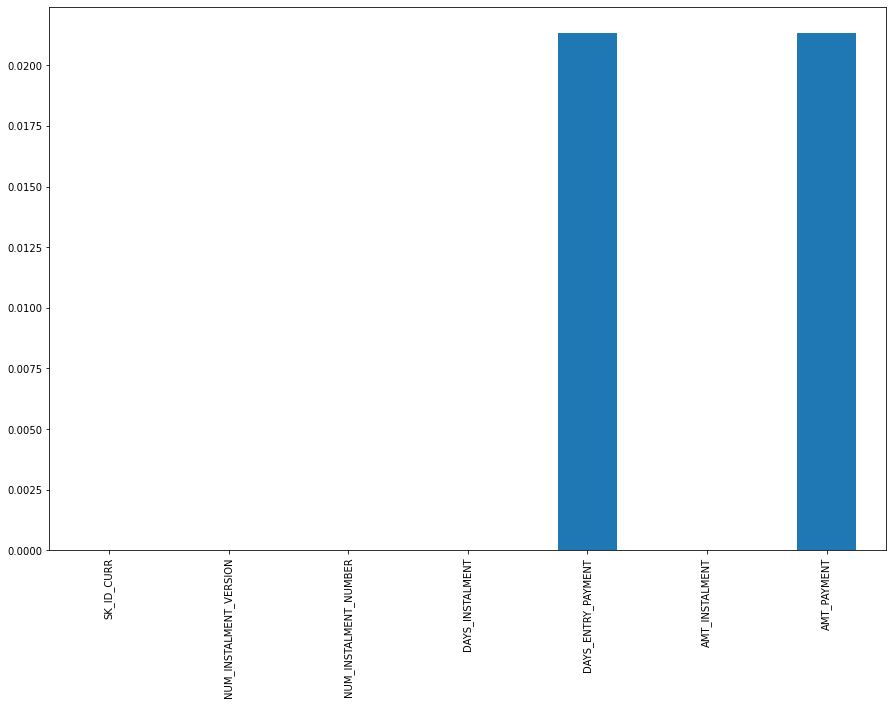

In [108]:
show_null_per_variable(df_installments_payments[get_numerical_categorical(df_installments_payments)[0]])

In [109]:
get_dtypes(df_installments_payments)

int32
int32
float32
int64
float32
float32
float32
float32


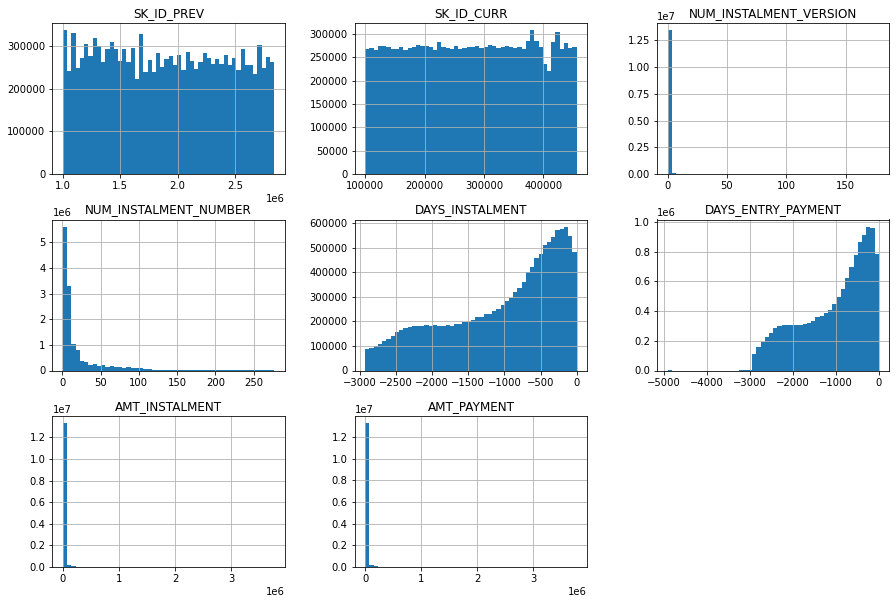

In [110]:
#transform_flag_variables (df_installments_payments)
#histogrammes
df_installments_payments.hist(bins=50, figsize= (15,10))
plt.show()

In [111]:
df_installments_payments['DIFF_DAYS_INS_PAY'] = df_installments_payments['DAYS_INSTALMENT'] - df_installments_payments['DAYS_ENTRY_PAYMENT']
df_installments_payments['DIFF_AMT_INS_PAY'] = df_installments_payments['AMT_INSTALMENT'] - df_installments_payments['AMT_PAYMENT']

In [112]:
df_installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DIFF_DAYS_INS_PAY,DIFF_AMT_INS_PAY
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863,7.0,0.000000
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024,0.0,0.000000
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000,0.0,0.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859,8.0,0.000000
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961,-17.0,4.455078


In [113]:
df_installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DIFF_DAYS_INS_PAY,DIFF_AMT_INS_PAY
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863,7.0,0.000000
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024,0.0,0.000000
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000,0.0,0.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859,8.0,0.000000
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961,-17.0,4.455078


In [114]:
df_POS_CASH_balance.describe()
to_keep_POS = missing_percentage_variable(df_POS_CASH_balance, 70)
df_POS_CASH_balance = df_POS_CASH_balance[to_keep_POS]

SK_ID_PREV > Missing values : 0 (0.0%)
SK_ID_CURR > Missing values : 0 (0.0%)
MONTHS_BALANCE > Missing values : 0 (0.0%)
CNT_INSTALMENT > Missing values : 26071 (0.3%)
CNT_INSTALMENT_FUTURE > Missing values : 26087 (0.3%)
NAME_CONTRACT_STATUS > Missing values : 0 (0.0%)
SK_DPD > Missing values : 0 (0.0%)
SK_DPD_DEF > Missing values : 0 (0.0%)


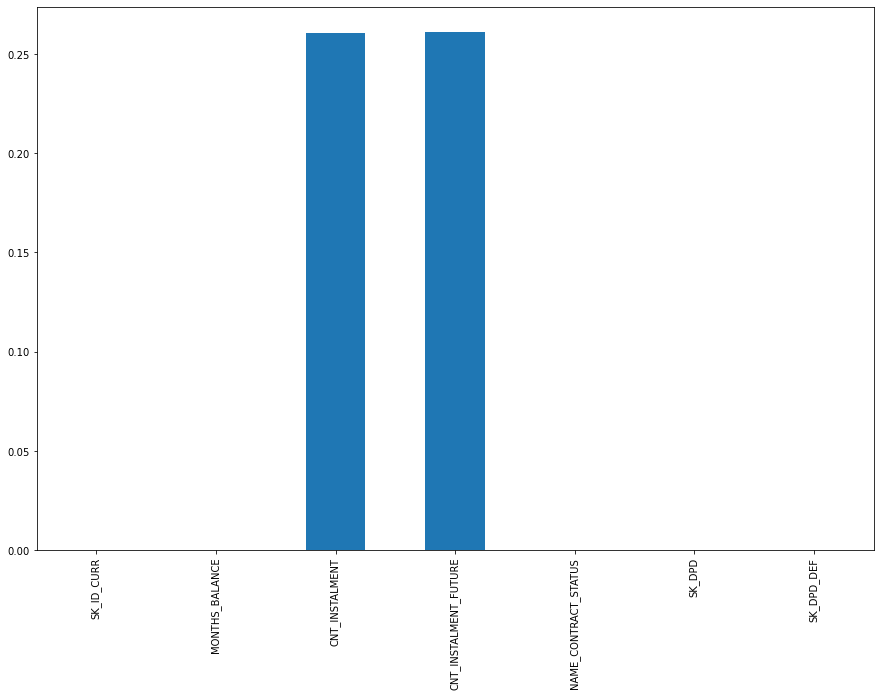

In [115]:
show_null_per_variable(df_POS_CASH_balance)

In [116]:
df_POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [117]:
get_dtypes(df_POS_CASH_balance)

int32
int32
int64
float32
float32
category
int64
int64


Valeurs nulles: 52158
Valeurs non nulles : 79958706
Pourcentage des valeurs nulles : 0.06518864738168556%
Valeurs nulles: 52158
Valeurs non nulles : 79958706
Pourcentage des valeurs nulles : 0.06518864738168556%


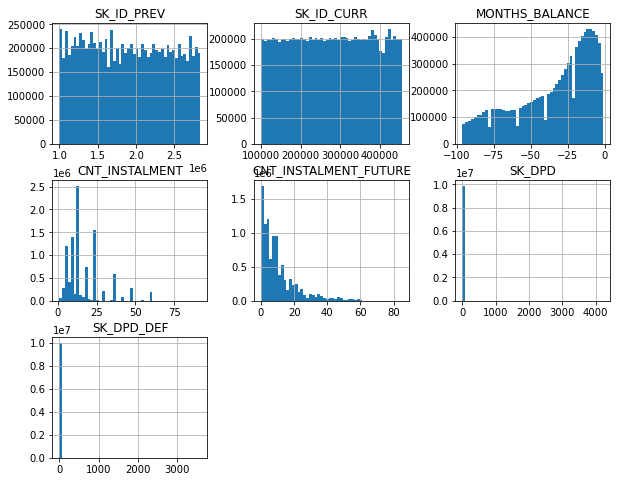

In [118]:
null_ratio(df_POS_CASH_balance)
df_POS_CASH_balance = transform_flag_variables (df_POS_CASH_balance)
null_ratio(df_POS_CASH_balance)
#histogrammes
df_POS_CASH_balance.hist(bins=50, figsize= (10,8))
plt.show()

In [119]:
df_previous_application.describe()
to_keep_prev = missing_percentage_variable(df_previous_application, 70)
df_previous_application = df_previous_application[to_keep_prev]

SK_ID_PREV > Missing values : 0 (0.0%)
SK_ID_CURR > Missing values : 0 (0.0%)
NAME_CONTRACT_TYPE > Missing values : 0 (0.0%)
AMT_ANNUITY > Missing values : 372235 (22.3%)
AMT_APPLICATION > Missing values : 0 (0.0%)
AMT_CREDIT > Missing values : 1 (0.0%)
AMT_DOWN_PAYMENT > Missing values : 895844 (53.6%)
AMT_GOODS_PRICE > Missing values : 385515 (23.1%)
WEEKDAY_APPR_PROCESS_START > Missing values : 0 (0.0%)
HOUR_APPR_PROCESS_START > Missing values : 0 (0.0%)
FLAG_LAST_APPL_PER_CONTRACT > Missing values : 0 (0.0%)
NFLAG_LAST_APPL_IN_DAY > Missing values : 0 (0.0%)
RATE_DOWN_PAYMENT > Missing values : 895844 (53.6%)
NAME_CASH_LOAN_PURPOSE > Missing values : 0 (0.0%)
NAME_CONTRACT_STATUS > Missing values : 0 (0.0%)
DAYS_DECISION > Missing values : 0 (0.0%)
NAME_PAYMENT_TYPE > Missing values : 0 (0.0%)
CODE_REJECT_REASON > Missing values : 0 (0.0%)
NAME_TYPE_SUITE > Missing values : 820405 (49.1%)
NAME_CLIENT_TYPE > Missing values : 0 (0.0%)
NAME_GOODS_CATEGORY > Missing values : 0 (0.0%)
N

In [120]:
df_previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,True,0.0,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,True,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,True,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,True,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,True,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


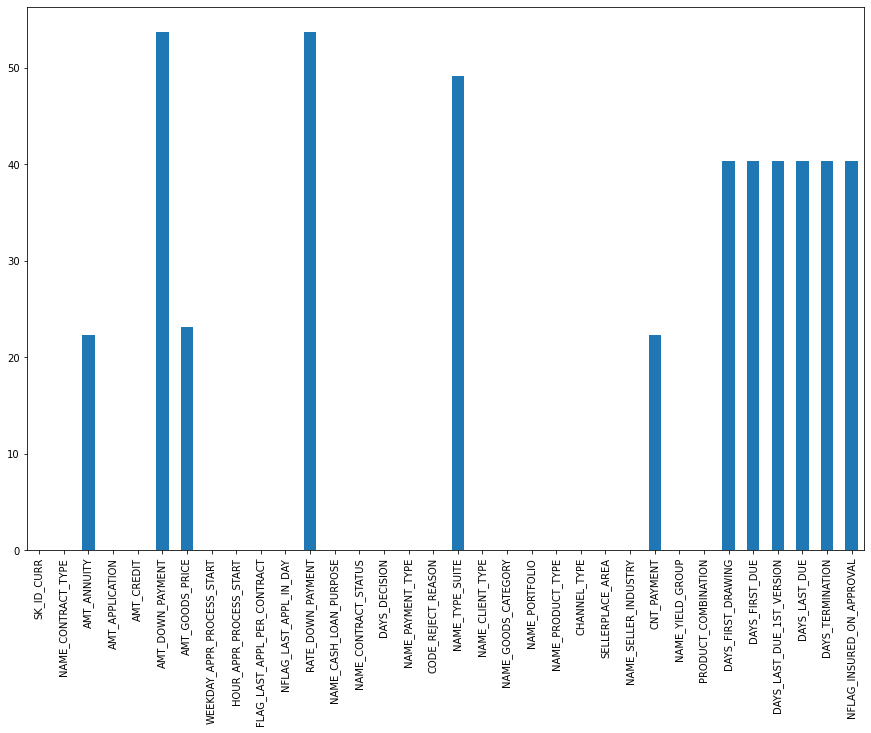

In [121]:
show_null_per_variable(df_previous_application)

In [122]:
null_ratio(df_previous_application)

Valeurs nulles: 7780810
Valeurs non nulles : 50676680
Pourcentage des valeurs nulles : 13.310201994646023%


In [123]:
get_dtypes(df_previous_application)

int32
int32
category
float32
float32
float32
float32
float32
category
int64
category
bool
float32
category
category
int64
category
category
category
category
category
category
category
category
int64
category
float32
category
category
float32
float32
float32
float32
float32
float32


Valeurs nulles: 7780810
Valeurs non nulles : 50676680
Pourcentage des valeurs nulles : 13.310201994646023%
[1. 0.]
Valeurs nulles: 7107745
Valeurs non nulles : 51349745
Pourcentage des valeurs nulles : 12.158826867181604%


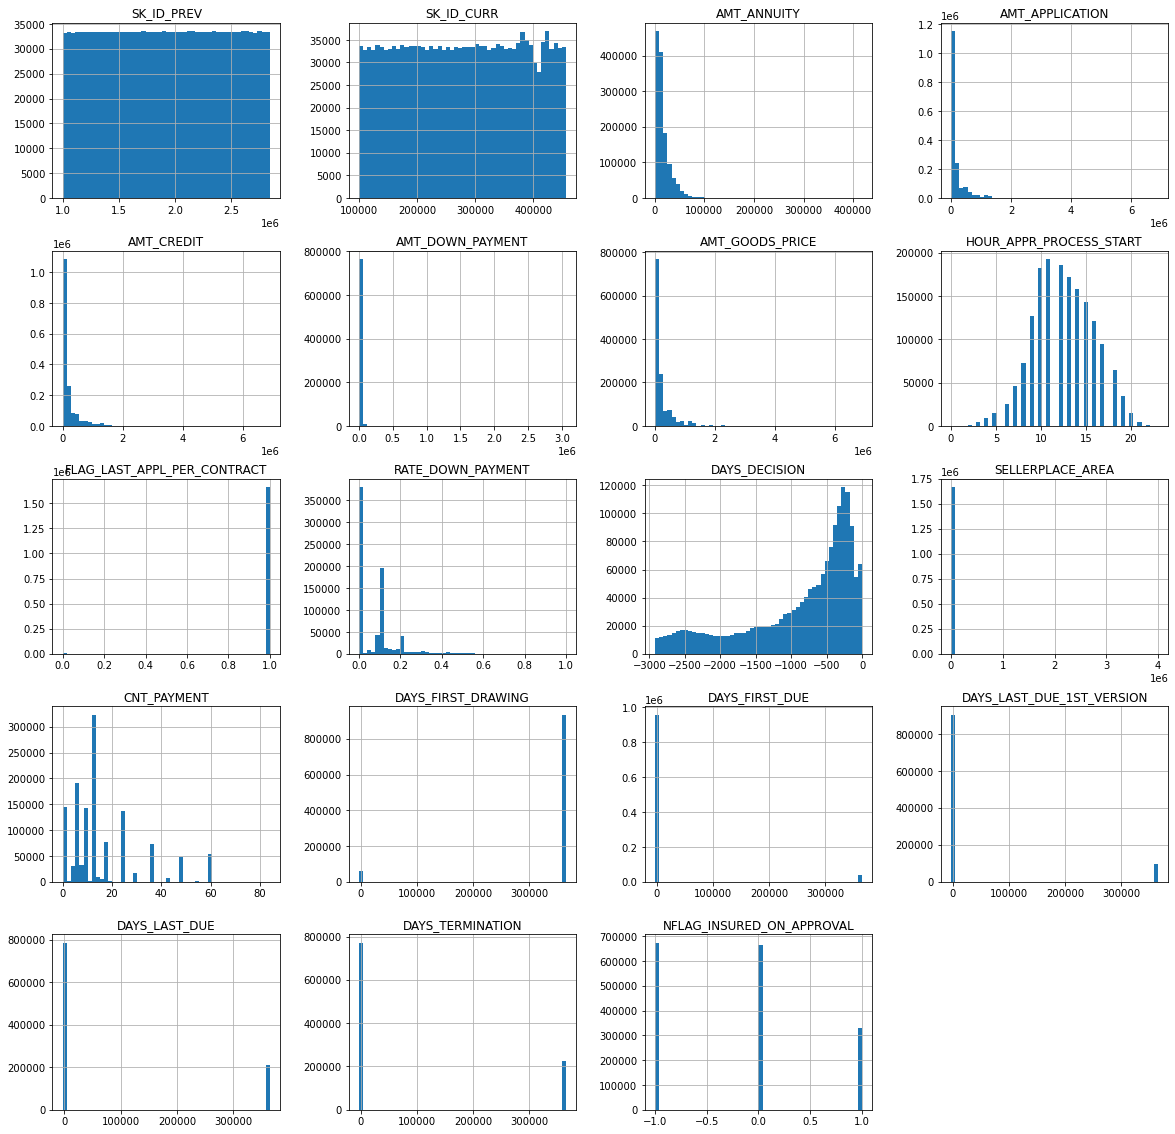

In [124]:
null_ratio(df_previous_application)
df_previous_application = transform_flag_variables (df_previous_application)
null_ratio(df_previous_application)
#histogrammes
df_previous_application[get_numerical_categorical(df_previous_application)[0]].hist(bins=50, figsize= (20,20))
plt.show()

In [125]:
non_log_columns_1 = ['SK_ID_PREV', 'SK_ID_CURR']
cat_prev = get_numerical_categorical(df_previous_application)[1]
for c in cat_prev :
    non_log_columns_1.append(c)


In [126]:
df_previous_application ['HOUR_APPR_PROCESS_START'].unique()

array([15, 11,  7,  9,  8, 10, 12, 13, 14, 16,  6,  4,  5, 19, 17, 18, 20,
       22, 21,  3,  1,  2, 23,  0], dtype=int64)

In [127]:
df_previous_application['PRODUCT_COMBINATION'].unique()

['POS mobile with interest', 'Cash X-Sell: low', 'Cash X-Sell: high', 'Cash X-Sell: middle', 'Cash Street: high', ..., 'Cash Street: low', 'POS industry without interest', 'Cash Street: middle', 'POS others without interest', NaN]
Length: 18
Categories (17, object): ['POS mobile with interest', 'Cash X-Sell: low', 'Cash X-Sell: high', 'Cash X-Sell: middle', ..., 'Cash Street: low', 'POS industry without interest', 'Cash Street: middle', 'POS others without interest']

In [128]:
WEEKDAY_APPR_PROCESS_START_dict = {0 : ['TUESDAY', 'FRIDAY', 'MONDAY', 'WEDNESDAY', 'THURSDAY'], 
                          1 :  ['SATURDAY', 'SUNDAY']} 


dict_list_1 = [WEEKDAY_APPR_PROCESS_START_dict]
unify(df_previous_application, dict_list_1)


WEEKDAY_APPR_PROCESS_START_dict
WEEKDAY_APPR_PROCESS_START


In [129]:
#df_previous_application ['HOUR_PROCESS_START'] = [] # 0 si entre minuit et 7h et 1 sinon

In [130]:
# normalize AMT application et AMT credit et AMT goods 
df_previous_application['AMT_DOWN_PAYMENT'].unique()
df_previous_application['DIFF_APP_CRE'] = df_previous_application['AMT_APPLICATION']/df_previous_application['AMT_CREDIT'] 
df_previous_application['DOWN_PERCENTAGE'] = df_previous_application['AMT_DOWN_PAYMENT'] /df_previous_application['AMT_CREDIT'] 
df_previous_application['DIFF_APP_GOODS'] = df_previous_application['AMT_APPLICATION']/df_previous_application['AMT_CREDIT']
df_previous_application['DIFF_CRE_GOODS'] = df_previous_application['AMT_CREDIT'] / df_previous_application['AMT_GOODS_PRICE']
df_previous_application['FLAG_DOWN'] = df_previous_application['AMT_DOWN_PAYMENT']
df_previous_application['FLAG_DOWN']  = df_previous_application['FLAG_DOWN'].apply(lambda x: 1 if x> 0 else 0) #1 si >0 0 sinon ou si nan

In [131]:
#df_previous_application[''] product_catacteristics.groupby(['SK_ID_CURR'])[''].transform('mean')
df_previous_application['DIFF_APP_CRE'] = df_previous_application.groupby(['SK_ID_CURR'])['DIFF_APP_CRE'].transform('mean') 
df_previous_application['DOWN_PERCENTAGE'] = df_previous_application.groupby(['SK_ID_CURR'])['DOWN_PERCENTAGE'].transform('mean') 
df_previous_application['DIFF_APP_GOODS'] = df_previous_application.groupby(['SK_ID_CURR'])['DIFF_APP_GOODS'].transform('mean')
df_previous_application['DIFF_CRE_GOODS'] = df_previous_application.groupby(['SK_ID_CURR'])['DIFF_CRE_GOODS'].transform('mean')
df_previous_application['FLAG_DOWN'] = df_previous_application.groupby(['SK_ID_CURR'])['FLAG_DOWN'].transform('max')

In [132]:
df_sample_submission.describe()

,SK_ID_CURR,TARGET
count,48744.000000,48744.0
mean,277796.676350,0.5
std,103169.547296,0.0
min,100001.000000,0.5
25%,188557.750000,0.5
50%,277549.000000,0.5
75%,367555.500000,0.5
max,456250.000000,0.5


In [133]:
df_sample_submission.head()

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5


In [134]:
get_dtypes(df_sample_submission)

int32
float32


In [135]:
df_sample_submission.shape

(48744, 2)

In [136]:
null_ratio(B)
print(B.shape)

Valeurs nulles: 4922862
Valeurs non nulles : 37987838
Pourcentage des valeurs nulles : 11.47234139736709%
(1716428, 25)


In [137]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,0.0,1.0,0,202500.0,406597.5,24700.5,351000.0,ALONE,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-16036.995067,-637,-3648.0,-2120,-1.0,1,1,0,1,1,0,2,1.0,2,2,WEED,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,reg oper account,block of flats,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,0.0,0.0,0,270000.0,1293502.5,35698.5,1129500.0,FAMILY,State servant,Higher education,Married,House / apartment,0.003541,-16036.995067,-1188,-1186.0,-291,-1.0,1,1,0,1,1,0,2,2.0,1,1,WEED,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,reg oper account,block of flats,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,1.0,1.0,0,67500.0,135000.0,6750.0,135000.0,ALONE,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-16036.995067,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,2,1.0,2,2,WEED,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,0.0,1.0,0,135000.0,312682.5,29686.5,297000.0,ALONE,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-16036.995067,-3039,-9833.0,-2437,-1.0,1,1,0,1,0,0,2,2.0,2,2,WEED,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,0.0,1.0,0,121500.0,513000.0,21865.5,513000.0,ALONE,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-16036.995067,-3038,-4311.0,-3458,-1.0,1,1,0,1,0,0,2,1.0,2,2,WEED,11,0,0,0,0,1,1,Religion,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
IC = df_installments_payments.copy()
PC = df_POS_CASH_balance.copy()
PA = df_previous_application.copy()
del df_POS_CASH_balance, df_previous_application , df_installments_payments
gc.collect()

121219

In [139]:
cat_prev_app = get_numerical_categorical(PA)[1]
print(cat_prev_app)
for c in cat_prev_app : 
    print (len(PA[c].unique()))
    if len(PA[c].unique()) > 5 :
        PA = PA.drop(c, axis =1)
    #print (PA[c].unique())

cat_prev_app = get_numerical_categorical(PA)[1]
PA[cat_prev_app].head()

['NAME_CONTRACT_TYPE', 'NFLAG_LAST_APPL_IN_DAY', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION']
4
2
25
4
4
9
8
4
28
5
3
8
11
5
18


,NAME_CONTRACT_TYPE,NFLAG_LAST_APPL_IN_DAY,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,NAME_CLIENT_TYPE,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,NAME_YIELD_GROUP
0,Consumer loans,True,Approved,Cash through the bank,Repeater,POS,XNA,middle
1,Cash loans,True,Approved,XNA,Repeater,Cash,x-sell,low_action
2,Cash loans,True,Approved,Cash through the bank,Repeater,Cash,x-sell,high
3,Cash loans,True,Approved,Cash through the bank,Repeater,Cash,x-sell,middle
4,Cash loans,True,Refused,Cash through the bank,Repeater,Cash,walk-in,high


In [140]:
print(cat_prev_app)

['NAME_CONTRACT_TYPE', 'NFLAG_LAST_APPL_IN_DAY', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'NAME_CLIENT_TYPE', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'NAME_YIELD_GROUP']


In [141]:
enc = OneHotEncoder(handle_unknown='ignore')

PA = one_hot_encoder(enc, PA, cat_prev_app)
PA.head()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,RATE_DOWN_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,DIFF_APP_CRE,DOWN_PERCENTAGE,DIFF_APP_GOODS,DIFF_CRE_GOODS,FLAG_DOWN,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,NFLAG_LAST_APPL_IN_DAY_False,NFLAG_LAST_APPL_IN_DAY_True,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cash through the bank,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_PORTFOLIO_Cards,NAME_PORTFOLIO_Cars,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PORTFOLIO_XNA,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle
0,2030495,271877,1730.430054,17145.0,17145.0,0.0,17145.0,1,15,1.0,0.0,-73,35,12.0,365243.0,-42.0,300.0,-42.0,-37.0,0.0,0.976761,0.034193,0.976761,1.026818,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1
1,2802425,108129,25188.615234,607500.0,679671.0,NaN,607500.0,0,11,1.0,NaN,-164,-1,36.0,365243.0,-134.0,916.0,365243.0,365243.0,1.0,0.961128,0.348278,0.961128,0.951747,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0
2,2523466,122040,15060.735352,112500.0,136444.5,NaN,112500.0,0,11,1.0,NaN,-301,-1,12.0,365243.0,-271.0,59.0,365243.0,365243.0,1.0,0.932643,0.053175,0.932643,1.084044,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
3,2819243,176158,47041.335938,450000.0,470790.0,NaN,450000.0,0,7,1.0,NaN,-512,-1,12.0,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,0.970251,0.010106,0.970251,1.033893,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
4,1784265,202054,31924.394531,337500.0,404055.0,NaN,337500.0,0,9,1.0,NaN,-781,-1,24.0,NaN,NaN,NaN,NaN,NaN,-1.0,0.902951,0.043601,0.902951,1.116905,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0


In [142]:
cat_prev_app_after = get_numerical_categorical(PA)[1]
print(cat_prev_app_after)
PA.columns

['NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Consumer loans', 'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_CONTRACT_TYPE_XNA', 'NFLAG_LAST_APPL_IN_DAY_False', 'NFLAG_LAST_APPL_IN_DAY_True', 'NAME_CONTRACT_STATUS_Approved', 'NAME_CONTRACT_STATUS_Canceled', 'NAME_CONTRACT_STATUS_Refused', 'NAME_CONTRACT_STATUS_Unused offer', 'NAME_PAYMENT_TYPE_Cash through the bank', 'NAME_PAYMENT_TYPE_Cashless from the account of the employer', 'NAME_PAYMENT_TYPE_Non-cash from your account', 'NAME_PAYMENT_TYPE_XNA', 'NAME_CLIENT_TYPE_New', 'NAME_CLIENT_TYPE_Refreshed', 'NAME_CLIENT_TYPE_Repeater', 'NAME_CLIENT_TYPE_XNA', 'NAME_PORTFOLIO_Cards', 'NAME_PORTFOLIO_Cars', 'NAME_PORTFOLIO_Cash', 'NAME_PORTFOLIO_POS', 'NAME_PORTFOLIO_XNA', 'NAME_PRODUCT_TYPE_XNA', 'NAME_PRODUCT_TYPE_walk-in', 'NAME_PRODUCT_TYPE_x-sell', 'NAME_YIELD_GROUP_XNA', 'NAME_YIELD_GROUP_high', 'NAME_YIELD_GROUP_low_action', 'NAME_YIELD_GROUP_low_normal', 'NAME_YIELD_GROUP_middle']


Index(['SK_ID_PREV', 'SK_ID_CURR', 'AMT_ANNUITY', 'AMT_APPLICATION',
       'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'RATE_DOWN_PAYMENT', 'DAYS_DECISION',
       'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING',
       'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE',
       'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL', 'DIFF_APP_CRE',
       'DOWN_PERCENTAGE', 'DIFF_APP_GOODS', 'DIFF_CRE_GOODS', 'FLAG_DOWN',
       'NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Consumer loans',
       'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_CONTRACT_TYPE_XNA',
       'NFLAG_LAST_APPL_IN_DAY_False', 'NFLAG_LAST_APPL_IN_DAY_True',
       'NAME_CONTRACT_STATUS_Approved', 'NAME_CONTRACT_STATUS_Canceled',
       'NAME_CONTRACT_STATUS_Refused', 'NAME_CONTRACT_STATUS_Unused offer',
       'NAME_PAYMENT_TYPE_Cash through the bank',
       'NAME_PAYMENT_TYPE_Cashle

In [143]:
PA.head()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,RATE_DOWN_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,DIFF_APP_CRE,DOWN_PERCENTAGE,DIFF_APP_GOODS,DIFF_CRE_GOODS,FLAG_DOWN,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,NFLAG_LAST_APPL_IN_DAY_False,NFLAG_LAST_APPL_IN_DAY_True,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cash through the bank,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_PORTFOLIO_Cards,NAME_PORTFOLIO_Cars,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PORTFOLIO_XNA,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle
0,2030495,271877,1730.430054,17145.0,17145.0,0.0,17145.0,1,15,1.0,0.0,-73,35,12.0,365243.0,-42.0,300.0,-42.0,-37.0,0.0,0.976761,0.034193,0.976761,1.026818,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1
1,2802425,108129,25188.615234,607500.0,679671.0,NaN,607500.0,0,11,1.0,NaN,-164,-1,36.0,365243.0,-134.0,916.0,365243.0,365243.0,1.0,0.961128,0.348278,0.961128,0.951747,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0
2,2523466,122040,15060.735352,112500.0,136444.5,NaN,112500.0,0,11,1.0,NaN,-301,-1,12.0,365243.0,-271.0,59.0,365243.0,365243.0,1.0,0.932643,0.053175,0.932643,1.084044,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
3,2819243,176158,47041.335938,450000.0,470790.0,NaN,450000.0,0,7,1.0,NaN,-512,-1,12.0,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,0.970251,0.010106,0.970251,1.033893,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
4,1784265,202054,31924.394531,337500.0,404055.0,NaN,337500.0,0,9,1.0,NaN,-781,-1,24.0,NaN,NaN,NaN,NaN,NaN,-1.0,0.902951,0.043601,0.902951,1.116905,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0


In [144]:
PA.shape

(1670214, 56)

In [145]:
null_ratio(PA)

Valeurs nulles: 6370868
Valeurs non nulles : 87161116
Pourcentage des valeurs nulles : 6.811432546967035%


In [146]:
PA = transform_flag_variables (PA)

[1. 0.]
[1 0]


In [147]:
def group_by_agregate(df,  column_new, column_origin, column_grouped, agragation) :
    if column_origin in get_numerical_categorical(df)[0]:
        if agragation =='sum':
            df[column_new] = df[column_origin]
            grp = df.groupby(by = column_grouped)[column_origin].sum().reset_index().rename(index = str, columns = {column_new :column_origin})
            df = df.merge(grp, on = column_grouped, how = 'left')
            del grp
            gc.collect()
        elif agragation =='mean':
            df[column_new] = df[column_origin]
            grp = df.groupby(by = column_grouped)[column_origin].mean().reset_index().rename(index = str, columns = {column_new : column_origin})
            df = df.merge(grp, on = column_grouped, how = 'left')
            del grp
            gc.collect()
        elif agragation =='max':
            df[column_new] = df[column_origin]
            grp = df.groupby(by = column_grouped)[column_origin].max().reset_index().rename(index = str, columns = {column_new : column_origin})
            df = df.merge(grp, on = column_grouped, how = 'left')
            del grp
            gc.collect()
        elif agragation =='min':
            df[column_new] = df[column_origin]
            grp = df.groupby(by = column_grouped)[column_origin].min().reset_index().rename(index = str, columns = {column_new : column_origin})
            df = df.merge(grp, on = column_grouped, how = 'left')
            del grp
            gc.collect()

        elif agragation =='most_common':
            df[column_new] = df[column_origin]
            grp = df.groupby(by = column_grouped)[column_origin].agg(lambda x:x.value_counts().index[0]).reset_index().rename(index = str, columns = {column_new : column_origin})
            df = df.merge(grp, on = column_grouped, how = 'left')
            del grp
            gc.collect()   
        
    return df
# agregation on columns 
sum_agg_columns = ['CNT_PAYMENT']
#merge  variables
for column in sum_agg_columns :
    new_column = 'TOT_'+column 
    PA = group_by_agregate(PA, new_column, column, 'SK_ID_CURR', 'sum')

PA.head()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,RATE_DOWN_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT_x,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,DIFF_APP_CRE,DOWN_PERCENTAGE,DIFF_APP_GOODS,DIFF_CRE_GOODS,FLAG_DOWN,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,NFLAG_LAST_APPL_IN_DAY_False,NFLAG_LAST_APPL_IN_DAY_True,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cash through the bank,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_PORTFOLIO_Cards,NAME_PORTFOLIO_Cars,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PORTFOLIO_XNA,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,TOT_CNT_PAYMENT,CNT_PAYMENT_y
0,2030495,271877,1730.430054,17145.0,17145.0,0.0,17145.0,1,15,1.0,0.0,-73,35,12.0,365243.0,-42.0,300.0,-42.0,-37.0,0.0,0.976761,0.034193,0.976761,1.026818,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,12.0,60.0
1,2802425,108129,25188.615234,607500.0,679671.0,NaN,607500.0,0,11,1.0,NaN,-164,-1,36.0,365243.0,-134.0,916.0,365243.0,365243.0,1.0,0.961128,0.348278,0.961128,0.951747,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,36.0,94.0
2,2523466,122040,15060.735352,112500.0,136444.5,NaN,112500.0,0,11,1.0,NaN,-301,-1,12.0,365243.0,-271.0,59.0,365243.0,365243.0,1.0,0.932643,0.053175,0.932643,1.084044,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,12.0,24.0
3,2819243,176158,47041.335938,450000.0,470790.0,NaN,450000.0,0,7,1.0,NaN,-512,-1,12.0,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,0.970251,0.010106,0.970251,1.033893,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,12.0,350.0
4,1784265,202054,31924.394531,337500.0,404055.0,NaN,337500.0,0,9,1.0,NaN,-781,-1,24.0,NaN,NaN,NaN,NaN,NaN,-1.0,0.902951,0.043601,0.902951,1.116905,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,24.0,343.0


In [148]:
mean_agg_columns = ['RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED',
                   'DIFF_APP_CRE','DOWN_PERCENTAGE','DIFF_APP_GOODS','DIFF_CRE_GOODS','FLAG_DOWN']
for column in mean_agg_columns :
    new_column = 'TOT_'+column 
    PA = group_by_agregate(PA, new_column , column, ['SK_ID_CURR'], 'mean')
    
PA.head()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,RATE_DOWN_PAYMENT_x,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT_x,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,DIFF_APP_CRE_x,DOWN_PERCENTAGE_x,DIFF_APP_GOODS_x,DIFF_CRE_GOODS_x,FLAG_DOWN_x,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,NFLAG_LAST_APPL_IN_DAY_False,NFLAG_LAST_APPL_IN_DAY_True,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cash through the bank,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_PORTFOLIO_Cards,NAME_PORTFOLIO_Cars,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PORTFOLIO_XNA,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,TOT_CNT_PAYMENT,CNT_PAYMENT_y,TOT_RATE_DOWN_PAYMENT,RATE_DOWN_PAYMENT_y,TOT_DIFF_APP_CRE,DIFF_APP_CRE_y,TOT_DOWN_PERCENTAGE,DOWN_PERCENTAGE_y,TOT_DIFF_APP_GOODS,DIFF_APP_GOODS_y,TOT_DIFF_CRE_GOODS,DIFF_CRE_GOODS_y,TOT_FLAG_DOWN,FLAG_DOWN_y
0,2030495,271877,1730.430054,17145.0,17145.0,0.0,17145.0,1,15,1.0,0.0,-73,35,12.0,365243.0,-42.0,300.0,-42.0,-37.0,0.0,0.976761,0.034193,0.976761,1.026818,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,12.0,60.0,0.0,0.033775,0.976761,0.976761,0.034193,0.034193,0.976761,0.976761,1.026818,1.026818,1,1
1,2802425,108129,25188.615234,607500.0,679671.0,NaN,607500.0,0,11,1.0,NaN,-164,-1,36.0,365243.0,-134.0,916.0,365243.0,365243.0,1.0,0.961128,0.348278,0.961128,0.951747,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,36.0,94.0,NaN,0.185495,0.961128,0.961128,0.348278,0.348278,0.961128,0.961128,0.951747,0.951747,1,1
2,2523466,122040,15060.735352,112500.0,136444.5,NaN,112500.0,0,11,1.0,NaN,-301,-1,12.0,365243.0,-271.0,59.0,365243.0,365243.0,1.0,0.932643,0.053175,0.932643,1.084044,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,12.0,24.0,NaN,0.052345,0.932643,0.932643,0.053175,0.053175,0.932643,0.932643,1.084044,1.084044,1,1
3,2819243,176158,47041.335938,450000.0,470790.0,NaN,450000.0,0,7,1.0,NaN,-512,-1,12.0,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,0.970251,0.010106,0.970251,1.033893,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,12.0,350.0,NaN,0.009905,0.970251,0.970251,0.010106,0.010106,0.970251,0.970251,1.033893,1.033893,1,1
4,1784265,202054,31924.394531,337500.0,404055.0,NaN,337500.0,0,9,1.0,NaN,-781,-1,24.0,NaN,NaN,NaN,NaN,NaN,-1.0,0.902951,0.043601,0.902951,1.116905,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,24.0,343.0,NaN,0.043452,0.902951,0.902951,0.043601,0.043601,0.902951,0.902951,1.116905,1.116905,1,1


In [149]:
min_agg_columns = [ 'DAYS_LAST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_FIRST_DUE', 'DAYS_FIRST_DRAWING']
for column in min_agg_columns :
    new_column = 'TOT_'+column 
    PA = group_by_agregate(PA, new_column , column, ['SK_ID_CURR'], 'min')
    

PA.head()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,RATE_DOWN_PAYMENT_x,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT_x,DAYS_FIRST_DRAWING_x,DAYS_FIRST_DUE_x,DAYS_LAST_DUE_1ST_VERSION_x,DAYS_LAST_DUE_x,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,DIFF_APP_CRE_x,DOWN_PERCENTAGE_x,DIFF_APP_GOODS_x,DIFF_CRE_GOODS_x,FLAG_DOWN_x,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,NFLAG_LAST_APPL_IN_DAY_False,NFLAG_LAST_APPL_IN_DAY_True,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cash through the bank,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_PORTFOLIO_Cards,NAME_PORTFOLIO_Cars,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PORTFOLIO_XNA,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,TOT_CNT_PAYMENT,CNT_PAYMENT_y,TOT_RATE_DOWN_PAYMENT,RATE_DOWN_PAYMENT_y,TOT_DIFF_APP_CRE,DIFF_APP_CRE_y,TOT_DOWN_PERCENTAGE,DOWN_PERCENTAGE_y,TOT_DIFF_APP_GOODS,DIFF_APP_GOODS_y,TOT_DIFF_CRE_GOODS,DIFF_CRE_GOODS_y,TOT_FLAG_DOWN,FLAG_DOWN_y,TOT_DAYS_LAST_DUE,DAYS_LAST_DUE_y,TOT_DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE_1ST_VERSION_y,TOT_DAYS_FIRST_DUE,DAYS_FIRST_DUE_y,TOT_DAYS_FIRST_DRAWING,DAYS_FIRST_DRAWING_y
0,2030495,271877,1730.430054,17145.0,17145.0,0.0,17145.0,1,15,1.0,0.0,-73,35,12.0,365243.0,-42.0,300.0,-42.0,-37.0,0.0,0.976761,0.034193,0.976761,1.026818,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,12.0,60.0,0.0,0.033775,0.976761,0.976761,0.034193,0.034193,0.976761,0.976761,1.026818,1.026818,1,1,-42.0,-392.0,300.0,-182.0,-42.0,-512.0,365243.0,365243.0
1,2802425,108129,25188.615234,607500.0,679671.0,NaN,607500.0,0,11,1.0,NaN,-164,-1,36.0,365243.0,-134.0,916.0,365243.0,365243.0,1.0,0.961128,0.348278,0.961128,0.951747,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,36.0,94.0,NaN,0.185495,0.961128,0.961128,0.348278,0.348278,0.961128,0.961128,0.951747,0.951747,1,1,365243.0,-846.0,916.0,-846.0,-134.0,-1176.0,365243.0,-713.0
2,2523466,122040,15060.735352,112500.0,136444.5,NaN,112500.0,0,11,1.0,NaN,-301,-1,12.0,365243.0,-271.0,59.0,365243.0,365243.0,1.0,0.932643,0.053175,0.932643,1.084044,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,12.0,24.0,NaN,0.052345,0.932643,0.932643,0.053175,0.053175,0.932643,0.932643,1.084044,1.084044,1,1,365243.0,-2425.0,59.0,-2215.0,-271.0,-2545.0,365243.0,-2405.0
3,2819243,176158,47041.335938,450000.0,470790.0,NaN,450000.0,0,7,1.0,NaN,-512,-1,12.0,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,0.970251,0.010106,0.970251,1.033893,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,12.0,350.0,NaN,0.009905,0.970251,0.970251,0.010106,0.010106,0.970251,0.970251,1.033893,1.033893,1,1,-182.0,-2389.0,-152.0,-2389.0,-482.0,-2659.0,365243.0,365243.0
4,1784265,202054,31924.394531,337500.0,404055.0,NaN,337500.0,0,9,1.0,NaN,-781,-1,24.0,NaN,NaN,NaN,NaN,NaN,-1.0,0.902951,0.043601,0.902951,1.116905,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,24.0,343.0,NaN,0.043452,0.902951,0.902951,0.043601,0.043601,0.902951,0.902951,1.116905,1.116905,1,1,NaN,-1484.0,NaN,-1484.0,NaN,-1814.0,NaN,-300.0


In [150]:
#'NAME_CONTRACT_TYPE', 'NFLAG_MICRO_CASH', 'WEEKDAY_APPR_PROCESS_START',  'NAME_PORTFOLIO', 'NFLAG_INSURED_ON_APPROVAL', 'CODE_REJECT_REASON',  'NFLAG_INSURED_ON_APPROVAL', 'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
#'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
most_common_agg_columns = ['DAYS_DECISION', 'NAME_PAYMENT_TYPE']
for column in most_common_agg_columns :
    new_column = 'TOT_'+column 
    PA = group_by_agregate(PA, new_column , column, ['SK_ID_CURR'], 'most_common')
    


In [151]:
max_agg_columns = ['NAME_CLIENT_TYPE']
for column in max_agg_columns :
    new_column = 'TOT_'+column 
    PA = group_by_agregate(PA, new_column , column, ['SK_ID_CURR'], 'max')

PA.head()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,RATE_DOWN_PAYMENT_x,DAYS_DECISION_x,SELLERPLACE_AREA,CNT_PAYMENT_x,DAYS_FIRST_DRAWING_x,DAYS_FIRST_DUE_x,DAYS_LAST_DUE_1ST_VERSION_x,DAYS_LAST_DUE_x,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,DIFF_APP_CRE_x,DOWN_PERCENTAGE_x,DIFF_APP_GOODS_x,DIFF_CRE_GOODS_x,FLAG_DOWN_x,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,NFLAG_LAST_APPL_IN_DAY_False,NFLAG_LAST_APPL_IN_DAY_True,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cash through the bank,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_PORTFOLIO_Cards,NAME_PORTFOLIO_Cars,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PORTFOLIO_XNA,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,TOT_CNT_PAYMENT,CNT_PAYMENT_y,TOT_RATE_DOWN_PAYMENT,RATE_DOWN_PAYMENT_y,TOT_DIFF_APP_CRE,DIFF_APP_CRE_y,TOT_DOWN_PERCENTAGE,DOWN_PERCENTAGE_y,TOT_DIFF_APP_GOODS,DIFF_APP_GOODS_y,TOT_DIFF_CRE_GOODS,DIFF_CRE_GOODS_y,TOT_FLAG_DOWN,FLAG_DOWN_y,TOT_DAYS_LAST_DUE,DAYS_LAST_DUE_y,TOT_DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE_1ST_VERSION_y,TOT_DAYS_FIRST_DUE,DAYS_FIRST_DUE_y,TOT_DAYS_FIRST_DRAWING,DAYS_FIRST_DRAWING_y,TOT_DAYS_DECISION,DAYS_DECISION_y
0,2030495,271877,1730.430054,17145.0,17145.0,0.0,17145.0,1,15,1.0,0.0,-73,35,12.0,365243.0,-42.0,300.0,-42.0,-37.0,0.0,0.976761,0.034193,0.976761,1.026818,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,12.0,60.0,0.0,0.033775,0.976761,0.976761,0.034193,0.034193,0.976761,0.976761,1.026818,1.026818,1,1,-42.0,-392.0,300.0,-182.0,-42.0,-512.0,365243.0,365243.0,-73,-472
1,2802425,108129,25188.615234,607500.0,679671.0,NaN,607500.0,0,11,1.0,NaN,-164,-1,36.0,365243.0,-134.0,916.0,365243.0,365243.0,1.0,0.961128,0.348278,0.961128,0.951747,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,36.0,94.0,NaN,0.185495,0.961128,0.961128,0.348278,0.348278,0.961128,0.961128,0.951747,0.951747,1,1,365243.0,-846.0,916.0,-846.0,-134.0,-1176.0,365243.0,-713.0,-164,-619
2,2523466,122040,15060.735352,112500.0,136444.5,NaN,112500.0,0,11,1.0,NaN,-301,-1,12.0,365243.0,-271.0,59.0,365243.0,365243.0,1.0,0.932643,0.053175,0.932643,1.084044,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,12.0,24.0,NaN,0.052345,0.932643,0.932643,0.053175,0.053175,0.932643,0.932643,1.084044,1.084044,1,1,365243.0,-2425.0,59.0,-2215.0,-271.0,-2545.0,365243.0,-2405.0,-301,-301
3,2819243,176158,47041.335938,450000.0,470790.0,NaN,450000.0,0,7,1.0,NaN,-512,-1,12.0,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,0.970251,0.010106,0.970251,1.033893,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,12.0,350.0,NaN,0.009905,0.970251,0.970251,0.010106,0.010106,0.970251,0.970251,1.033893,1.033893,1,1,-182.0,-2389.0,-152.0,-2389.0,-482.0,-2659.0,365243.0,365243.0,-512,-2415
4,1784265,202054,31924.394531,337500.0,404055.0,NaN,337500.0,0,9,1.0,NaN,-781,-1,24.0,NaN,NaN,NaN,NaN,NaN,-1.0,0.902951,0.043601,0.902951,1.116905,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,24.0,343.0,NaN,0.043452,0.902951,0.902951,0.043601,0.043601,0.902951,0.902951,1.116905,1.116905,1,1,NaN,-1484.0,NaN,-1484.0,NaN,-1814.0,NaN,-300.0,-781,-34


In [152]:
new_columns_prev = ['SK_ID_PREV', 'SK_ID_CURR']

for c in sum_agg_columns :
    new_columns_prev.append('TOT_'+c)
for c in mean_agg_columns :
    new_columns_prev.append('TOT_'+c)
for c in min_agg_columns :
    new_columns_prev.append('TOT_'+c)
for c in most_common_agg_columns :
    new_columns_prev.append('TOT_'+c)
for c in max_agg_columns :
    new_columns_prev.append('TOT_'+c)
    
print("--------------------")
print(new_columns_prev)

--------------------
['SK_ID_PREV', 'SK_ID_CURR', 'TOT_CNT_PAYMENT', 'TOT_RATE_DOWN_PAYMENT', 'TOT_RATE_INTEREST_PRIMARY', 'TOT_RATE_INTEREST_PRIVILEGED', 'TOT_DIFF_APP_CRE', 'TOT_DOWN_PERCENTAGE', 'TOT_DIFF_APP_GOODS', 'TOT_DIFF_CRE_GOODS', 'TOT_FLAG_DOWN', 'TOT_DAYS_LAST_DUE', 'TOT_DAYS_LAST_DUE_1ST_VERSION', 'TOT_DAYS_FIRST_DUE', 'TOT_DAYS_FIRST_DRAWING', 'TOT_DAYS_DECISION', 'TOT_NAME_PAYMENT_TYPE', 'TOT_NAME_CLIENT_TYPE']


In [153]:
print(PA.shape)
PA = PA.groupby('SK_ID_CURR').mean().reset_index()
PA = PA.drop('SK_ID_PREV', axis =1)
PA = PA.drop_duplicates()
print(PA.shape)

(1670214, 80)
(338857, 79)


In [154]:
print(IC.columns)
print(IC.shape)

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT', 'DIFF_DAYS_INS_PAY',
       'DIFF_AMT_INS_PAY'],
      dtype='object')
(13605401, 10)


In [155]:
IC.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DIFF_DAYS_INS_PAY,DIFF_AMT_INS_PAY
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863,7.0,0.000000
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024,0.0,0.000000
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000,0.0,0.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859,8.0,0.000000
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961,-17.0,4.455078


In [156]:
ins_agg_columns_max = ['NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER']
ins_agg_columns_sum = ['AMT_INSTALMENT', 'AMT_PAYMENT' , 'DIFF_AMT_INS_PAY']
ins_agg_columns_min = ['DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'DIFF_DAYS_INS_PAY' ]

for column in ins_agg_columns_sum :
    new_column = 'TOT_'+column 
    IC = group_by_agregate(IC, new_column , column, ['SK_ID_PREV', 'SK_ID_CURR'], 'sum')
    
for column in ins_agg_columns_min :
    new_column = 'TOT_'+column 
    IC = group_by_agregate(IC, new_column , column, ['SK_ID_PREV', 'SK_ID_CURR'], 'min')
                           
for column in ins_agg_columns_max :
    new_column = 'TOT_'+column 
    IC = group_by_agregate(IC, new_column , column, ['SK_ID_PREV', 'SK_ID_CURR'], 'max')

In [157]:
IC = IC.drop_duplicates()
new_columns = ['SK_ID_PREV', 'SK_ID_CURR']
for c in ins_agg_columns_max :
    new_columns.append('TOT_'+c)
for c in ins_agg_columns_sum :
    new_columns.append('TOT_'+c)
for c in ins_agg_columns_min :
    new_columns.append('TOT_'+c)
    
print("--------------------")
print(new_columns)

--------------------
['SK_ID_PREV', 'SK_ID_CURR', 'TOT_NUM_INSTALMENT_VERSION', 'TOT_NUM_INSTALMENT_NUMBER', 'TOT_AMT_INSTALMENT', 'TOT_AMT_PAYMENT', 'TOT_DIFF_AMT_INS_PAY', 'TOT_DAYS_INSTALMENT', 'TOT_DAYS_ENTRY_PAYMENT', 'TOT_DIFF_DAYS_INS_PAY']


In [158]:
print(IC.columns)
#IC = IC[new_columns]


#IC = IC.drop_duplicates()
#print(IC.shape)

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION_x',
       'NUM_INSTALMENT_NUMBER_x', 'DAYS_INSTALMENT_x', 'DAYS_ENTRY_PAYMENT_x',
       'AMT_INSTALMENT_x', 'AMT_PAYMENT_x', 'DIFF_DAYS_INS_PAY_x',
       'DIFF_AMT_INS_PAY_x', 'TOT_AMT_INSTALMENT', 'AMT_INSTALMENT_y',
       'TOT_AMT_PAYMENT', 'AMT_PAYMENT_y', 'TOT_DIFF_AMT_INS_PAY',
       'DIFF_AMT_INS_PAY_y', 'TOT_DAYS_INSTALMENT', 'DAYS_INSTALMENT_y',
       'TOT_DAYS_ENTRY_PAYMENT', 'DAYS_ENTRY_PAYMENT_y',
       'TOT_DIFF_DAYS_INS_PAY', 'DIFF_DAYS_INS_PAY_y',
       'TOT_NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_VERSION_y',
       'TOT_NUM_INSTALMENT_NUMBER', 'NUM_INSTALMENT_NUMBER_y'],
      dtype='object')


In [159]:
IC = IC.groupby('SK_ID_CURR').mean().reset_index()
IC = IC.drop('SK_ID_PREV', axis =1)
IC = IC.drop_duplicates()
print(IC.shape)

(339587, 25)


In [160]:
IC.head()

,SK_ID_CURR,NUM_INSTALMENT_VERSION_x,NUM_INSTALMENT_NUMBER_x,DAYS_INSTALMENT_x,DAYS_ENTRY_PAYMENT_x,AMT_INSTALMENT_x,AMT_PAYMENT_x,DIFF_DAYS_INS_PAY_x,DIFF_AMT_INS_PAY_x,TOT_AMT_INSTALMENT,AMT_INSTALMENT_y,TOT_AMT_PAYMENT,AMT_PAYMENT_y,TOT_DIFF_AMT_INS_PAY,DIFF_AMT_INS_PAY_y,TOT_DAYS_INSTALMENT,DAYS_INSTALMENT_y,TOT_DAYS_ENTRY_PAYMENT,DAYS_ENTRY_PAYMENT_y,TOT_DIFF_DAYS_INS_PAY,DIFF_DAYS_INS_PAY_y,TOT_NUM_INSTALMENT_VERSION,NUM_INSTALMENT_VERSION_y,TOT_NUM_INSTALMENT_NUMBER,NUM_INSTALMENT_NUMBER_y
0,100001,1.142857,2.714286,-2187.714355,-2195.000000,5885.132324,5885.132324,7.285714,0.0,5885.132324,21834.097656,5885.132324,21834.097656,0.0,0.0,-2187.714355,-2226.285645,-2195.000000,-2229.714355,7.285714,-1.285714,1.142857,1.571429,2.714286,4.00
1,100002,1.052632,10.000000,-295.000000,-315.421051,11559.247070,11559.247070,20.421053,0.0,11559.247070,219625.703125,11559.247070,219625.703125,0.0,0.0,-295.000000,-565.000000,-315.421051,-587.000000,20.421053,12.000000,1.052632,2.000000,10.000000,19.00
2,100003,1.040000,5.080000,-1378.160034,-1385.319946,64754.585938,64754.585938,7.160000,0.0,64754.585938,453952.218750,64754.585938,453952.218750,0.0,0.0,-1378.160034,-1500.560059,-1385.319946,-1510.280029,7.160000,3.480000,1.040000,1.280000,5.080000,9.16
3,100004,1.333333,2.000000,-754.000000,-761.666687,7096.154785,7096.154785,7.666667,0.0,7096.154785,21288.464844,7096.154785,21288.464844,0.0,0.0,-754.000000,-784.000000,-761.666687,-795.000000,7.666667,3.000000,1.333333,2.000000,2.000000,3.00
4,100005,1.111111,5.000000,-586.000000,-609.555542,6240.205078,6240.205078,23.555555,0.0,6240.205078,56161.843750,6240.205078,56161.843750,0.0,0.0,-586.000000,-706.000000,-609.555542,-736.000000,23.555555,-1.000000,1.111111,2.000000,5.000000,9.00


In [161]:
print(PC.columns)
print(PC.shape)

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')
(10001358, 8)


In [162]:
pos_agg_columns_sum = ['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']
pos_agg_columns_max = ['NAME_CONTRACT_STATUS' ]
pos_agg_columns_min = ['MONTHS_BALANCE' ]
pos_agg_columns_mean = ['SK_DPD', 'SK_DPD_DEF']

for column in pos_agg_columns_sum :
    new_column = 'TOT_'+column 
    PC = group_by_agregate(PC, new_column , column, ['SK_ID_PREV', 'SK_ID_CURR'], 'sum')
    
for column in pos_agg_columns_min :
    new_column = 'TOT_'+column 
    PC = group_by_agregate(PC, new_column , column, ['SK_ID_PREV', 'SK_ID_CURR'], 'min')
                           
for column in pos_agg_columns_max :
    new_column = 'TOT_'+column 
    PC = group_by_agregate(PC, new_column , column, ['SK_ID_PREV', 'SK_ID_CURR'], 'max')

for column in pos_agg_columns_mean :
    new_column = 'TOT_'+column 
    PC = group_by_agregate(PC, new_column , column, ['SK_ID_PREV', 'SK_ID_CURR'], 'mean')

In [163]:
PC = PC.drop_duplicates()
new_columns_pos = ['SK_ID_PREV', 'SK_ID_CURR']
for c in pos_agg_columns_max :
    new_columns_pos.append('TOT_'+c)
for c in pos_agg_columns_sum :
    new_columns_pos.append('TOT_'+c)
for c in pos_agg_columns_min :
    new_columns_pos.append('TOT_'+c)
for c in pos_agg_columns_mean :
    new_columns_pos.append('TOT_'+c)
    


In [164]:
print("--------------------")
print(new_columns_pos)

#PC = PC[new_columns_pos]
print(PC.columns)
PC = PC.drop_duplicates()
print(PC.shape)

PC = PC.groupby('SK_ID_CURR').mean().reset_index()
PC = PC.drop('SK_ID_PREV', axis =1)
#PC = PC.drop_duplicates()
print(PC.shape)

--------------------
['SK_ID_PREV', 'SK_ID_CURR', 'TOT_NAME_CONTRACT_STATUS', 'TOT_CNT_INSTALMENT', 'TOT_CNT_INSTALMENT_FUTURE', 'TOT_MONTHS_BALANCE', 'TOT_SK_DPD', 'TOT_SK_DPD_DEF']
Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE_x', 'CNT_INSTALMENT_x',
       'CNT_INSTALMENT_FUTURE_x', 'NAME_CONTRACT_STATUS', 'SK_DPD_x',
       'SK_DPD_DEF_x', 'TOT_CNT_INSTALMENT', 'CNT_INSTALMENT_y',
       'TOT_CNT_INSTALMENT_FUTURE', 'CNT_INSTALMENT_FUTURE_y',
       'TOT_MONTHS_BALANCE', 'MONTHS_BALANCE_y', 'TOT_SK_DPD', 'SK_DPD_y',
       'TOT_SK_DPD_DEF', 'SK_DPD_DEF_y'],
      dtype='object')
(10001358, 18)
(337252, 16)


In [165]:
print(PC.shape)

(337252, 16)


In [166]:
# create a final dataframe containing train and test 
data = pd.DataFrame()
frames = [train, test]
data = pd.concat(frames)

In [167]:
B_copy = B.copy()
B_copy = B.groupby('SK_ID_CURR').mean().reset_index()

In [168]:
CCB_copy = CCB.copy()
CCB_copy = CCB.groupby('SK_ID_CURR').mean().reset_index()

In [169]:
#data = pd.concat([data, B], axis=1, join="inner")
data = data.merge(B_copy, on = ['SK_ID_CURR'], how = 'left')
print(data.shape)
data = data.drop_duplicates()
#data = data.drop(['SK_ID_BUREAU'])
print(data.shape)

(356255, 100)
(356255, 100)


In [170]:
data = data.merge(CCB_copy, on = ['SK_ID_CURR'], how = 'left')
print(data.shape)
data = data.drop_duplicates()
print(data.shape)

(356255, 128)
(356255, 128)


In [171]:
data = data.merge(PA, on = ['SK_ID_CURR'], how = 'left')
print(data.shape)
data = data.drop_duplicates()
print(data.shape)

(356255, 206)
(356255, 206)


In [172]:
null_ratio(data)

Valeurs nulles: 11908582
Valeurs non nulles : 61479948
Pourcentage des valeurs nulles : 16.22676186592101%


In [173]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_x,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,MIN_MONTH,AVERAGE_LOAN_TYPE,ACTIVE_LOANS_PERCENTAGE,DAYS_DIFF,CREDIT_ENDDATE_PERCENTAGE,DEBT_CREDIT_RATIO,OVERDUE_DEBT_RATIO,AVG_CREDITDAYS_PROLONGED,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,INSTALLMENTS_PER_LOAN,CREDIT_LOAD,DPD_COUNT,AVG_DPD,PERCENTAGE_MISSED_PAYMENTS,CASH_CARD_RATIO,DRAWINGS_RATIO,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT_y,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE_y,WEEKDAY_APPR_PROCESS_START_y,HOUR_APPR_PROCESS_START_y,FLAG_LAST_APPL_PER_CONTRACT,RATE_DOWN_PAYMENT_x,DAYS_DECISION_x,SELLERPLACE_AREA,CNT_PAYMENT_x,DAYS_FIRST_DRAWING_x,DAYS_FIRST_DUE_x,DAYS_LAST_DUE_1ST_VERSION_x,DAYS_LAST_DUE_x,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,DIFF_APP_CRE_x,DOWN_PERCENTAGE_x,DIFF_APP_GOODS_x,DIFF_CRE_GOODS_x,FLAG_DOWN_x,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,NFLAG_LAST_APPL_IN_DAY_False,NFLAG_LAST_APPL_IN_DAY_True,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cash through the bank,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_PORTFOLIO_Cards,NAME_PORTFOLIO_Cars,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PORTFOLIO_XNA,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,TOT_CNT_PAYMENT,CNT_PAYMENT_y,TOT_RATE_DOWN_PAYMENT,RATE_DOWN_PAYMENT_y,TOT_DIFF_APP_CRE,DIFF_APP_CRE_y,TOT_DOWN_PERCENTAGE,DOWN_PERCENTAGE_y,TOT_DIFF_APP_GOODS,DIFF_APP_GOODS_y,TOT_DIFF_CRE_GOODS,DIFF_CRE_GOODS_y,TOT_FLAG_DOWN,FLAG_DOWN_y,TOT_DAYS_LAST_DUE,DAYS_LAST_DUE_y,TOT_DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE_1ST_VERSIO

In [174]:
#onehotencoding et transformation log après l'ingénierie des variables
#cat_prev_cols = print_unique_values(data)
cat_prev_cols = []
num=[]
print(data.columns)
for y in data.columns : 
    print(y)
    #print(data[y].dtype )
    if 'AMT_ANNUITY_' not in y  :
        if (data[y].dtype == numpy.float64 or data[y].dtype == numpy.int64 or data[y].dtype == numpy.float32 or data[y].dtype == numpy.int32 ):
            num.append(y)
        else :
            if len(data[y].unique()) > 5 :
                data = data.drop(y, axis =1)
            else :
                cat_prev_cols.append(y)
#data['AMT_ANNUITY_x'].head()
data = one_hot_encoder(enc, data, cat_prev_cols)
data.head()

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT_x', 'AMT_ANNUITY_x',
       ...
       'TOT_DAYS_LAST_DUE', 'DAYS_LAST_DUE_y', 'TOT_DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE_1ST_VERSION_y', 'TOT_DAYS_FIRST_DUE', 'DAYS_FIRST_DUE_y',
       'TOT_DAYS_FIRST_DRAWING', 'DAYS_FIRST_DRAWING_y', 'TOT_DAYS_DECISION',
       'DAYS_DECISION_y'],
      dtype='object', length=206)
SK_ID_CURR
TARGET
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT_x
AMT_ANNUITY_x
AMT_GOODS_PRICE_x
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
OCCUPATION_TYPE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
W

,SK_ID_CURR,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,MIN_MONTH,AVERAGE_LOAN_TYPE,ACTIVE_LOANS_PERCENTAGE,DAYS_DIFF,CREDIT_ENDDATE_PERCENTAGE,DEBT_CREDIT_RATIO,OVERDUE_DEBT_RATIO,AVG_CREDITDAYS_PROLONGED,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,INSTALLMENTS_PER_LOAN,CREDIT_LOAD,DPD_COUNT,AVG_DPD,PERCENTAGE_MISSED_PAYMENTS,CASH_CARD_RATIO,DRAWINGS_RATIO,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT_y,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE_y,WEEKDAY_APPR_PROCESS_START_y,HOUR_APPR_PROCESS_START_y,FLAG_LAST_APPL_PER_CONTRACT,RATE_DOWN_PAYMENT_x,DAYS_DECISION_x,SELLERPLACE_AREA,CNT_PAYMENT_x,DAYS_FIRST_DRAWING_x,DAYS_FIRST_DUE_x,DAYS_LAST_DUE_1ST_VERSION_x,DAYS_LAST_DUE_x,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,DIFF_APP_CRE_x,DOWN_PERCENTAGE_x,DIFF_APP_GOODS_x,DIFF_CRE_GOODS_x,FLAG_DOWN_x,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,NFLAG_LAST_APPL_IN_DAY_False,NFLAG_LAST_APPL_IN_DAY_True,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cash through the bank,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_PORTFOLIO_Cards,NAME_PORTFOLIO_Cars,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PORTFOLIO_XNA,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,TOT_CNT_PAYMENT,CNT_PAYMENT_y,TOT_RATE_DOWN_PAYMENT,RATE_DOWN_PAYMENT_y,TOT_DIFF_APP_CRE,DIFF_APP_CRE_y,TOT_DOWN_PERCENTAGE,DOWN_PERCENTAGE_y,TOT_DIFF_APP_GOODS,DIFF_APP_GOODS_y,TOT_DIFF_CRE_GOODS,DIFF_CRE_GOODS_y,TOT_FLAG_DOWN,FLAG_DOWN_y,TOT_DAYS_LAST_DUE,DAYS_LAST_DUE_y,TOT_DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE_1ST_VERSION_y,TOT_DAYS_FIRST_DUE,DAYS_FIRST_DUE_y,TOT_DAYS_FIRST_DRAWING,DAYS_FIRST_DRAWING_y,TOT_DAYS_DECISION,DAYS_DECISION_y,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,NAME_TYPE_SUITE_ALONE,NAME_TYP

In [175]:
data_1 = data.copy()
data_1 = data_1.dropna()
print(data_1.shape)
print(null_ratio(data))

(5887, 216)
Valeurs nulles: 11139376
Valeurs non nulles : 65811704
Pourcentage des valeurs nulles : 14.475918986452172%
None


In [176]:
to_keep_credit_balance = missing_percentage_variable(data, 70)

SK_ID_CURR > Missing values : 0 (0.0%)
TARGET > Missing values : 0 (0.0%)
FLAG_OWN_CAR > Missing values : 0 (0.0%)
FLAG_OWN_REALTY > Missing values : 0 (0.0%)
CNT_CHILDREN > Missing values : 0 (0.0%)
AMT_INCOME_TOTAL > Missing values : 0 (0.0%)
AMT_CREDIT_x > Missing values : 0 (0.0%)
AMT_ANNUITY_x > Missing values : 36 (0.0%)
AMT_GOODS_PRICE_x > Missing values : 278 (0.1%)
REGION_POPULATION_RELATIVE > Missing values : 0 (0.0%)
DAYS_BIRTH > Missing values : 0 (0.0%)
DAYS_EMPLOYED > Missing values : 0 (0.0%)
DAYS_REGISTRATION > Missing values : 0 (0.0%)
DAYS_ID_PUBLISH > Missing values : 0 (0.0%)
OWN_CAR_AGE > Missing values : 32312 (9.1%)
FLAG_MOBIL > Missing values : 0 (0.0%)
FLAG_EMP_PHONE > Missing values : 0 (0.0%)
FLAG_WORK_PHONE > Missing values : 0 (0.0%)
FLAG_CONT_MOBILE > Missing values : 0 (0.0%)
FLAG_PHONE > Missing values : 0 (0.0%)
FLAG_EMAIL > Missing values : 0 (0.0%)
CNT_FAM_MEMBERS > Missing values : 2 (0.0%)
REGION_RATING_CLIENT > Missing values : 0 (0.0%)
REGION_RATI

TOT_DAYS_FIRST_DRAWING > Missing values : 18915 (5.3%)
DAYS_FIRST_DRAWING_y > Missing values : 18915 (5.3%)
TOT_DAYS_DECISION > Missing values : 17398 (4.9%)
DAYS_DECISION_y > Missing values : 17398 (4.9%)
NAME_CONTRACT_TYPE_Cash loans > Missing values : 0 (0.0%)
NAME_CONTRACT_TYPE_Revolving loans > Missing values : 0 (0.0%)
CODE_GENDER_F > Missing values : 0 (0.0%)
CODE_GENDER_M > Missing values : 0 (0.0%)
CODE_GENDER_XNA > Missing values : 0 (0.0%)
NAME_TYPE_SUITE_ALONE > Missing values : 0 (0.0%)
NAME_TYPE_SUITE_FAMILY > Missing values : 0 (0.0%)
NAME_TYPE_SUITE_OTHER > Missing values : 0 (0.0%)
NAME_EDUCATION_TYPE_Academic degree > Missing values : 0 (0.0%)
NAME_EDUCATION_TYPE_Higher education > Missing values : 0 (0.0%)
NAME_EDUCATION_TYPE_Incomplete higher > Missing values : 0 (0.0%)
NAME_EDUCATION_TYPE_Lower secondary > Missing values : 0 (0.0%)
NAME_EDUCATION_TYPE_Secondary / secondary special > Missing values : 0 (0.0%)
WEEKDAY_APPR_PROCESS_START_x_WEED > Missing values : 0 (0

In [177]:
data = data.drop(['AMT_ANNUITY_x', 'AMT_ANNUITY_y'], axis =1)

In [178]:
def transform_variables_log(df, columns):
    for c in columns :
        log_c = 'LOG_'+c
        df[log_c]= df[c]
        for index, row in df.iterrows():
            
            if row[c] == np.nan :
                row[log_c] = np.nan
            else :
                row[log_c] = numpy.log2(abs(float(row[c]))+0.0001)
        df= df.drop(c, axis=1)  
    #df= df.drop(columns, axis=1)
    return df

ids = column_with_type (df_application_train, 'SK_ID')
ids.append('TARGET')
elements = [ele for ele in data.columns if ele not in ids]
data = transform_variables_log(data, elements)

ValueError: Wrong number of items passed 2, placement implies 1

In [179]:
data.head()

,SK_ID_CURR,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,MIN_MONTH,AVERAGE_LOAN_TYPE,ACTIVE_LOANS_PERCENTAGE,DAYS_DIFF,CREDIT_ENDDATE_PERCENTAGE,DEBT_CREDIT_RATIO,OVERDUE_DEBT_RATIO,AVG_CREDITDAYS_PROLONGED,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,INSTALLMENTS_PER_LOAN,CREDIT_LOAD,DPD_COUNT,AVG_DPD,PERCENTAGE_MISSED_PAYMENTS,CASH_CARD_RATIO,DRAWINGS_RATIO,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT_y,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE_y,WEEKDAY_APPR_PROCESS_START_y,HOUR_APPR_PROCESS_START_y,FLAG_LAST_APPL_PER_CONTRACT,RATE_DOWN_PAYMENT_x,DAYS_DECISION_x,SELLERPLACE_AREA,CNT_PAYMENT_x,DAYS_FIRST_DRAWING_x,DAYS_FIRST_DUE_x,DAYS_LAST_DUE_1ST_VERSION_x,DAYS_LAST_DUE_x,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,DIFF_APP_CRE_x,DOWN_PERCENTAGE_x,DIFF_APP_GOODS_x,DIFF_CRE_GOODS_x,FLAG_DOWN_x,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,NFLAG_LAST_APPL_IN_DAY_False,NFLAG_LAST_APPL_IN_DAY_True,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cash through the bank,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_PORTFOLIO_Cards,NAME_PORTFOLIO_Cars,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PORTFOLIO_XNA,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,TOT_CNT_PAYMENT,CNT_PAYMENT_y,TOT_RATE_DOWN_PAYMENT,RATE_DOWN_PAYMENT_y,TOT_DIFF_APP_CRE,DIFF_APP_CRE_y,TOT_DOWN_PERCENTAGE,DOWN_PERCENTAGE_y,TOT_DIFF_APP_GOODS,DIFF_APP_GOODS_y,TOT_DIFF_CRE_GOODS,DIFF_CRE_GOODS_y,TOT_FLAG_DOWN,FLAG_DOWN_y,TOT_DAYS_LAST_DUE,DAYS_LAST_DUE_y,TOT_DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE_1ST_VERSION_y,TOT_DAYS_FIRST_DUE,DAYS_FIRST_DUE_y,TOT_DAYS_FIRST_DRAWING,DAYS_FIRST_DRAWING_y,TOT_DAYS_DECISION,DAYS_DECISION_y,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,NAME_TYPE_SUITE_ALONE,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUI

In [180]:
data = data[data['TARGET'] !=0.5]

# ANOVA: 

* la question à poser est : les revenus sont ils variables selon l'attribut ORGANIZATION_TYPE
* on considére un sous échantillon de produit (avec des nutri grade précis pour chaque variable quanti: déduit des boxplots)  qu'on évalue la normalité puis on applique ANOVA afin de remplir la condition de normalité de variable 

In [1]:
data_1 = data.copy()
data_1 = data_1.fillna(0)
data_1 = data_1[~data_1.isin([np.nan, np.inf, -np.inf]).any(1)]
data_1 = data_1.loc[:,~data_1.columns.duplicated()]
print(data_1.shape)


NameError: name 'data' is not defined

In [184]:
t = ['TARGET']
not_target= [ele for ele in data.columns if ele not in t]
final_columns = []
i=1
for c in not_target :
    if 'SK_ID' not in c :
        print(c)
        print(i)
        value = one_way_anova(data_1, 'TARGET', c) 
        if value :
            final_columns.append(c)
        i= i+1
        #test_anova(data_1, 'TARGET', c) 
print(len(final_columns))

FLAG_OWN_CAR
1
F=150.624, p=0.000
Probablement dépendants
FLAG_OWN_REALTY
2
F=11.583, p=0.001
Probablement dépendants
CNT_CHILDREN
3
F=111.473, p=0.000
Probablement dépendants
AMT_INCOME_TOTAL
4
F=4.791, p=0.029
Probablement dépendants
AMT_CREDIT_x
5
F=282.594, p=0.000
Probablement dépendants
AMT_GOODS_PRICE_x
6
F=478.844, p=0.000
Probablement dépendants
REGION_POPULATION_RELATIVE
7
F=416.082, p=0.000
Probablement dépendants
DAYS_BIRTH
8
F=nan, p=nan
Probablement dépendants
DAYS_EMPLOYED
9
F=614.454, p=0.000
Probablement dépendants
DAYS_REGISTRATION
10
F=533.715, p=0.000
Probablement dépendants
DAYS_ID_PUBLISH
11
F=807.010, p=0.000
Probablement dépendants
OWN_CAR_AGE
12
F=0.211, p=0.646
Probablement indépendants
FLAG_MOBIL
13
F=0.088, p=0.767
Probablement indépendants
FLAG_EMP_PHONE
14
F=643.511, p=0.000
Probablement dépendants
FLAG_WORK_PHONE
15
F=248.071, p=0.000
Probablement dépendants
FLAG_CONT_MOBILE
16
F=0.039, p=0.844
Probablement indépendants
FLAG_PHONE
17
F=173.959, p=0.000
Pr

F=546.617, p=0.000
Probablement dépendants
FLAG_DOWN_x
131
F=186.728, p=0.000
Probablement dépendants
NAME_CONTRACT_TYPE_Cash loans
132
F=105.439, p=0.000
Probablement dépendants
NAME_CONTRACT_TYPE_Consumer loans
133
F=167.990, p=0.000
Probablement dépendants
NAME_CONTRACT_TYPE_Revolving loans
134
F=505.390, p=0.000
Probablement dépendants
NAME_CONTRACT_TYPE_XNA
135
F=22.382, p=0.000
Probablement dépendants
NFLAG_LAST_APPL_IN_DAY_False
136
F=4.659, p=0.031
Probablement dépendants
NFLAG_LAST_APPL_IN_DAY_True
137
F=98.672, p=0.000
Probablement dépendants
NAME_CONTRACT_STATUS_Approved
138
F=523.939, p=0.000
Probablement dépendants
NAME_CONTRACT_STATUS_Canceled
139
F=64.168, p=0.000
Probablement dépendants
NAME_CONTRACT_STATUS_Refused
140
F=1865.403, p=0.000
Probablement dépendants
NAME_CONTRACT_STATUS_Unused offer
141
F=1.069, p=0.301
Probablement indépendants
NAME_PAYMENT_TYPE_Cash through the bank
142
F=141.271, p=0.000
Probablement dépendants
NAME_PAYMENT_TYPE_Cashless from the account

In [185]:
final_columns = [ele for ele in final_columns if ele not in t]


target_df= data_1['TARGET']
data_1 = data_1[final_columns]

std_scale = StandardScaler().fit(data_1)
data_scaled = std_scale.transform(data_1)
final_data = pd.DataFrame(data_scaled, columns= data_1.columns)

In [186]:
null_ratio(final_data)

Valeurs nulles: 0
Valeurs non nulles : 11845977
Pourcentage des valeurs nulles : 0.0%


## Gestion du déséquilibre des données avec SMOTE 

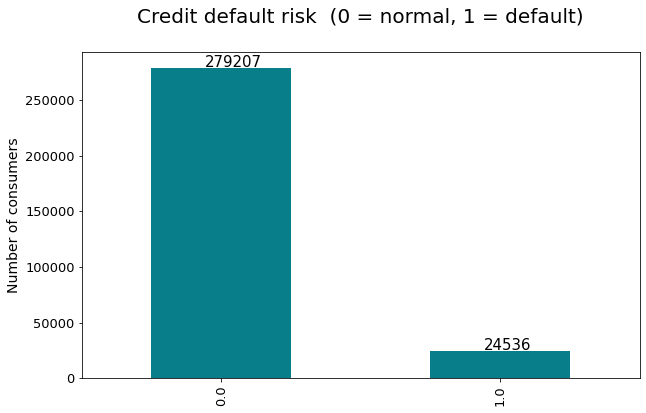

In [187]:

ax = target_df.value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='#087E8B')
ax.set_title('Credit default risk  (0 = normal, 1 = default)', size=20, pad=30)
ax.set_ylabel('Number of consumers', fontsize=14)

for i in ax.patches:
    ax.text(i.get_x() + 0.19, i.get_height() + 700, str(round(i.get_height(), 2)), fontsize=15)


In [188]:
#new dataset values
target = ['SK_ID_CURR','SK_ID_BUREAU', 'TARGET']
elements = [ele for ele in final_data.columns if ele not in target]

In [189]:
print(final_data[elements].shape)


(303743, 39)


In [191]:
def handle_unbalanced_data(X, y):
    sm = SMOTE(random_state=42)
    X_sm, y_sm = sm.fit_resample(np.array(X), y.ravel())

    print(f'''Shape of X before SMOTE: {X.shape} Shape of X after SMOTE: {X_sm.shape}''')
    
    v = pd.DataFrame(y_sm).value_counts(normalize=True) * 100
    print(f'''Balance of positive and negative classes (%):{v}''')
    X= pd.DataFrame(X_sm, columns = X.columns)
    y= pd.DataFrame(y_sm, columns = ['TARGET'])
    return X, y


In [193]:
X, y = handle_unbalanced_data(final_data[elements],target_df)

Shape of X before SMOTE: (303743, 39) Shape of X after SMOTE: (558414, 39)
Balance of positive and negative classes (%):1.0    50.0
0.0    50.0
dtype: float64


In [194]:
X.shape

(558414, 39)

In [195]:
y.shape

(558414, 1)

In [196]:
final_banking_data = X
final_banking_data ['TARGET'] = y['TARGET']

In [197]:
final_banking_data.head()

,OWN_CAR_AGE,FLAG_MOBIL,FLAG_CONT_MOBILE,FLAG_EMAIL,LIVE_REGION_NOT_WORK_REGION,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_7,FLAG_DOCUMENT_10,FLAG_DOCUMENT_12,FLAG_DOCUMENT_17,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,OVERDUE_DEBT_RATIO,AVG_CREDITDAYS_PROLONGED,SK_DPD,INSTALLMENTS_PER_LOAN,DPD_COUNT,AVG_DPD,DRAWINGS_RATIO,SELLERPLACE_AREA,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_PORTFOLIO_Cars,CODE_GENDER_XNA,NAME_TYPE_SUITE_OTHER,NAME_EDUCATION_TYPE_Incomplete higher,WEEKDAY_APPR_PROCESS_START_x_WEED,WEEKDAY_APPR_PROCESS_START_x_WEEKEND,FONDKAPREMONT_MODE_not specified,HOUSETYPE_MODE_terraced house,TARGET
0,-0.476657,0.001814,0.043474,-0.244193,-0.206035,-0.009073,-0.123841,-0.013938,-0.004801,-0.002566,-0.016433,-0.024486,-0.022668,-0.070919,-0.058673,-0.155793,-0.006094,-0.110072,-0.006092,-0.110072,-0.0502,-0.33417,-0.12837,-0.0502,-0.273437,0.010213,-0.211956,-0.038592,-0.105164,-1.410073,-0.047553,-0.024793,-0.003629,-0.11781,-0.185991,0.440695,-0.440695,-0.136964,-0.062662,1.0
1,-0.476657,0.001814,0.043474,-0.244193,-0.206035,-0.009073,-0.123841,-0.013938,-0.004801,-0.002566,-0.016433,-0.024486,-0.022668,-0.070919,-0.058673,-0.155793,-0.013145,-0.110072,-0.006092,-0.110072,-0.0502,-0.33417,-0.12837,-0.0502,-0.273437,0.013357,-0.211956,-0.038592,-0.105164,-0.499048,-0.047553,-0.024793,-0.003629,-0.11781,-0.185991,0.440695,-0.440695,-0.136964,-0.062662,0.0
2,2.418427,0.001814,0.043474,-0.244193,-0.206035,-0.009073,-0.123841,-0.013938,-0.004801,-0.002566,-0.016433,-0.024486,-0.022668,-0.070919,-0.058673,-0.155793,-0.013145,-0.110072,-0.006092,-0.110072,-0.0502,-0.33417,-0.12837,-0.0502,-0.273437,-0.034564,-0.211956,-0.038592,-0.105164,-1.410073,-0.047553,-0.024793,-0.003629,-0.11781,-0.185991,0.440695,-0.440695,-0.136964,-0.062662,0.0
3,-0.476657,0.001814,0.043474,-0.244193,-0.206035,-0.009073,-0.123841,-0.013938,-0.004801,-0.002566,-0.016433,-0.024486,-0.022668,-0.070919,-0.058673,-0.155793,-0.013145,-0.110072,-0.006092,-0.110072,-0.0502,-0.33417,-0.12837,-0.0502,-0.273437,0.047770,-0.211956,-0.038592,-0.105164,1.019327,-0.047553,-0.024793,-0.003629,-0.11781,-0.185991,0.440695,-0.440695,-0.136964,-0.062662,0.0
4,-0.476657,0.001814,0.043474,-0.244193,-0.206035,-0.009073,-0.123841,-0.013938,-0.004801,-0.002566,-0.016433,-0.024486,-0.022668,-0.070919,-0.058673,-0.155793,-0.013145,-0.110072,-0.006092,-0.110072,-0.0502,-0.33417,-0.12837,-0.0502,-0.273437,0.001559,-0.211956,-0.038592,-0.105164,0.867489,-0.047553,-0.024793,-0.003629,-0.11781,-0.185991,0.440695,-0.440695,-0.136964,-0.062662,0.0


In [198]:
# Check correlation
cor = final_banking_data[elements].corr()
cor.loc[:,:] = np.tril(cor, k=-1) 
cor = cor.stack()
cor[(cor > 0.7) | (cor < -0.7)]

AVG_CREDITDAYS_PROLONGED              CNT_CREDIT_PROLONG                   1.000000
DPD_COUNT                             SK_DPD                               0.785811
AVG_DPD                               SK_DPD                               1.000000
                                      DPD_COUNT                            0.785811
WEEKDAY_APPR_PROCESS_START_x_WEEKEND  WEEKDAY_APPR_PROCESS_START_x_WEED   -1.000000
dtype: float64

In [199]:
final_banking_data.head()

,OWN_CAR_AGE,FLAG_MOBIL,FLAG_CONT_MOBILE,FLAG_EMAIL,LIVE_REGION_NOT_WORK_REGION,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_7,FLAG_DOCUMENT_10,FLAG_DOCUMENT_12,FLAG_DOCUMENT_17,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,OVERDUE_DEBT_RATIO,AVG_CREDITDAYS_PROLONGED,SK_DPD,INSTALLMENTS_PER_LOAN,DPD_COUNT,AVG_DPD,DRAWINGS_RATIO,SELLERPLACE_AREA,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_PORTFOLIO_Cars,CODE_GENDER_XNA,NAME_TYPE_SUITE_OTHER,NAME_EDUCATION_TYPE_Incomplete higher,WEEKDAY_APPR_PROCESS_START_x_WEED,WEEKDAY_APPR_PROCESS_START_x_WEEKEND,FONDKAPREMONT_MODE_not specified,HOUSETYPE_MODE_terraced house,TARGET
0,-0.476657,0.001814,0.043474,-0.244193,-0.206035,-0.009073,-0.123841,-0.013938,-0.004801,-0.002566,-0.016433,-0.024486,-0.022668,-0.070919,-0.058673,-0.155793,-0.006094,-0.110072,-0.006092,-0.110072,-0.0502,-0.33417,-0.12837,-0.0502,-0.273437,0.010213,-0.211956,-0.038592,-0.105164,-1.410073,-0.047553,-0.024793,-0.003629,-0.11781,-0.185991,0.440695,-0.440695,-0.136964,-0.062662,1.0
1,-0.476657,0.001814,0.043474,-0.244193,-0.206035,-0.009073,-0.123841,-0.013938,-0.004801,-0.002566,-0.016433,-0.024486,-0.022668,-0.070919,-0.058673,-0.155793,-0.013145,-0.110072,-0.006092,-0.110072,-0.0502,-0.33417,-0.12837,-0.0502,-0.273437,0.013357,-0.211956,-0.038592,-0.105164,-0.499048,-0.047553,-0.024793,-0.003629,-0.11781,-0.185991,0.440695,-0.440695,-0.136964,-0.062662,0.0
2,2.418427,0.001814,0.043474,-0.244193,-0.206035,-0.009073,-0.123841,-0.013938,-0.004801,-0.002566,-0.016433,-0.024486,-0.022668,-0.070919,-0.058673,-0.155793,-0.013145,-0.110072,-0.006092,-0.110072,-0.0502,-0.33417,-0.12837,-0.0502,-0.273437,-0.034564,-0.211956,-0.038592,-0.105164,-1.410073,-0.047553,-0.024793,-0.003629,-0.11781,-0.185991,0.440695,-0.440695,-0.136964,-0.062662,0.0
3,-0.476657,0.001814,0.043474,-0.244193,-0.206035,-0.009073,-0.123841,-0.013938,-0.004801,-0.002566,-0.016433,-0.024486,-0.022668,-0.070919,-0.058673,-0.155793,-0.013145,-0.110072,-0.006092,-0.110072,-0.0502,-0.33417,-0.12837,-0.0502,-0.273437,0.047770,-0.211956,-0.038592,-0.105164,1.019327,-0.047553,-0.024793,-0.003629,-0.11781,-0.185991,0.440695,-0.440695,-0.136964,-0.062662,0.0
4,-0.476657,0.001814,0.043474,-0.244193,-0.206035,-0.009073,-0.123841,-0.013938,-0.004801,-0.002566,-0.016433,-0.024486,-0.022668,-0.070919,-0.058673,-0.155793,-0.013145,-0.110072,-0.006092,-0.110072,-0.0502,-0.33417,-0.12837,-0.0502,-0.273437,0.001559,-0.211956,-0.038592,-0.105164,0.867489,-0.047553,-0.024793,-0.003629,-0.11781,-0.185991,0.440695,-0.440695,-0.136964,-0.062662,0.0


In [200]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return(dataset)

In [201]:
final_banking_data = correlation(final_banking_data, 0.9)

In [202]:
final_banking_data.shape

(558414, 38)

## Client Classification 
* we compute a score representing risks related to the client profile and we deduce wether the client should be given or not the loan --> the score represents a probability 
### Examples with pycaret

In [203]:

#setting the experiment
reg_experiment = setup(final_banking_data, 
                       target = 'TARGET', 
                       session_id=123, 
                       log_experiment=True, 
                       experiment_name='ca_banking')

,Description,Value
0,session_id,123
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(558414, 38)"
5,Missing Values,False
6,Numeric Features,31
7,Categorical Features,6
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
#best_model = compare_models(exclude=['xgboost'], fold=5)
best_model = compare_models(exclude=[], fold=5)

In [ ]:
def create_tune_model(model_name):
    model  = create_model(model_name)
    tuned_model = tune_model(model, n_iter=50, optimize = 'Recall')
    print('Residual Plot')
    plot_model(tuned_model)
    print('Prediction Error')
    plot_model(tuned_model, plot = 'error')
    print('Feature Importances')
    plot_model(tuned_model, plot = 'feature')
    print('Model evaluation')
    evaluate_model(tuned_model)
    print('Model interpretation')
    interpret_model(tuned_model)
    

In [ ]:
# best models
create_tune_model('lightgbm')

In [ ]:
# best models
create_tune_model('rf')

In [ ]:
# best models
create_tune_model('xgboost')

In [ ]:
# best models
create_tune_model('qda')

 ## SHAP (SHapley Additive exPlanations)
* How To Calculate the Shapley Values for one feature?
* This value is the average marginal contribution of a feature value across all the possible combinations of features.

In [ ]:
elements_1 = [ele for ele in final_banking_data.columns if ele not in target]
X = final_banking_data[elements_1]
y = final_banking_data['TARGET']

In [ ]:
# roc curve and auc


trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
model = LogisticRegression(solver='lbfgs')


    
roc_curve_aux (trainX, testX, trainy, testy, model)

In [ ]:

# define the model
model_1 = create_model("lightgbm")
#model_1 = LogisticRegression(solver='lbfgs')

trainX = trainX.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
testX = testX.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

roc_curve_aux (trainX, testX, trainy, testy, model_1)

In [ ]:

# define the model
model_1 = create_model("et")
#model_1 = LogisticRegression(solver='lbfgs')

trainX = trainX.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
testX = testX.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

roc_curve_aux (trainX, testX, trainy, testy, model_1)

In [ ]:

# load JS visualization code to notebook
shap.initjs()
explainer = shap.TreeExplainer(model_1)
shap_values = explainer.shap_values(X)
Noushap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')


In [ ]:
def Find_Optimal_Threshold(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 


In [ ]:

#trainX, testX, trainy, testy, model_1
# Add prediction probability to dataframe
testX['pred_proba'] = model_1.predict(testX)

# Find optimal probability threshold
threshold = Find_Optimal_Threshold(testy, testX['pred_proba'])
print threshold
# [0.31762762459360921]

# Find prediction to the dataframe applying threshold
testX['pred'] = testX['pred_proba'].map(lambda x: 1 if x > threshold else 0)

# Print confusion Matrix

confusion_matrix(testy, testX['pred'])

## save model 

In [ ]:

# create an iterator object with write permission - model.pkl
with open('model_pkl', 'wb') as files:
    pickle.dump(model, files)

In [ ]:
# load saved model
with open('model_pkl' , 'rb') as f:
    lr = pickle.load(f)